# Introduction

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fa/American_Society_of_Heating%2C_Refrigerating_and_Air-Conditioning_Engineers_Logo.svg/1200px-American_Society_of_Heating%2C_Refrigerating_and_Air-Conditioning_Engineers_Logo.svg.png" width=200 height=200 />

In this competition we are to create a model to predict an energy usage per building **and** per meter. 

We are given a dataset of around 1450 buildings containing such information as building id, which is a unique identifier of a building across both train and test dataset. Meter - is the type of meter that measures the data - energy consumption in kWh. Different buildings might have different meters installed. Some of them have only one type of meter, some have all four. 

So we need to make a predictions for each meter of each building.


# Content
[Loading data](#1)

[Amount of data and NaNs](#data_amount)

[Mean meter reading by day](#2)

[Number of observations by day](#3)

### Features:
* [Meter](#meter)
* [Site_id](#site_id)
* [primary_use](#primary_use)
* [square_feet](#square_feet)
* [year_built](#year_built)
* [floor_count](#floor_count)
* [building_id](#building_id)
* [air_temperature](#air_temperature)
* [cloud_coverage](#cloud_coverage)
* [dew_temperature](#dew_temperature)
* [precip_depth_1_hr](#precip_depth_1_hr)
* [wind_direction & wind_speed](#wind_direction)

### Engineered features:
* [Observation hour](#Observation_hour)
* [Observation day of month](#observ_day)
* [Observation day of week](#observ_weekday)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

<a id="1"></a>
# Loading data

In [2]:
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

## Merging everything into two datasets: train and test

In [3]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

In [4]:
# Saving some memory
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

<a id="data_amount"></a>
# Amount of data and NaNs

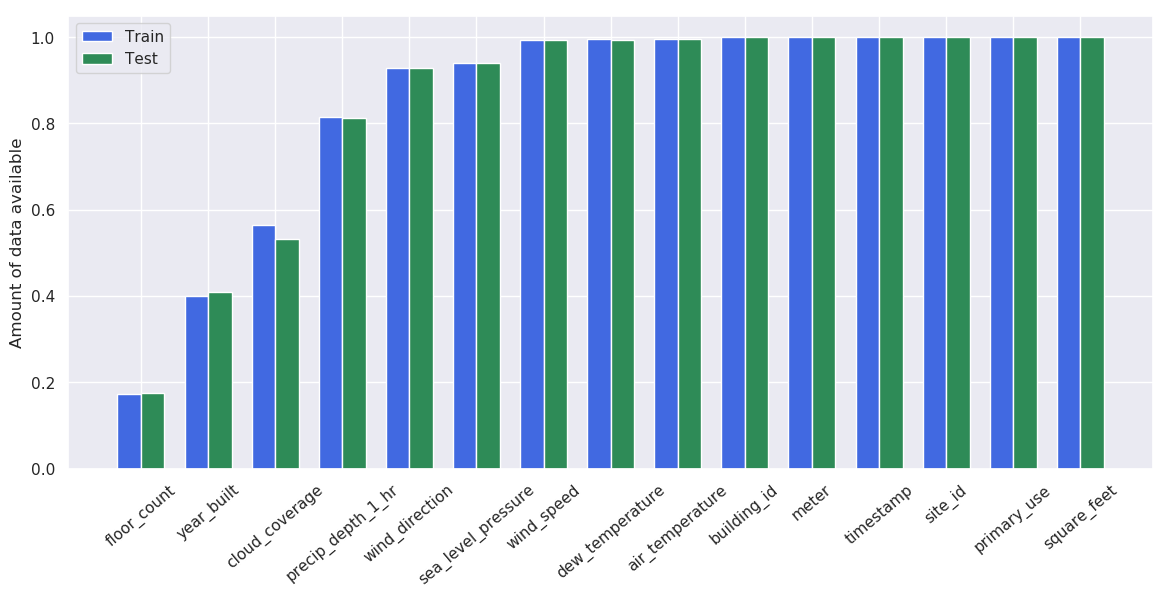

In [5]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

<a id="2"></a>
# Mean meter reading by day

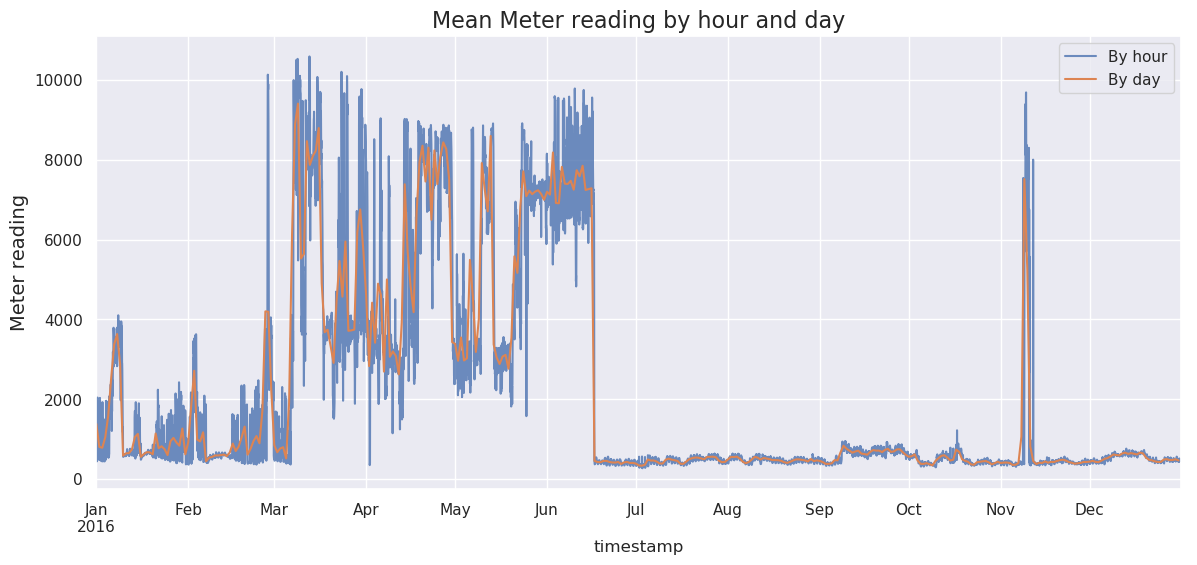

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

Doesn't this look weird? First reading are at the avarege level from January to March, then they explode from March to June and then drop down to almost zero with some peak at November.

Lets take a closer look.

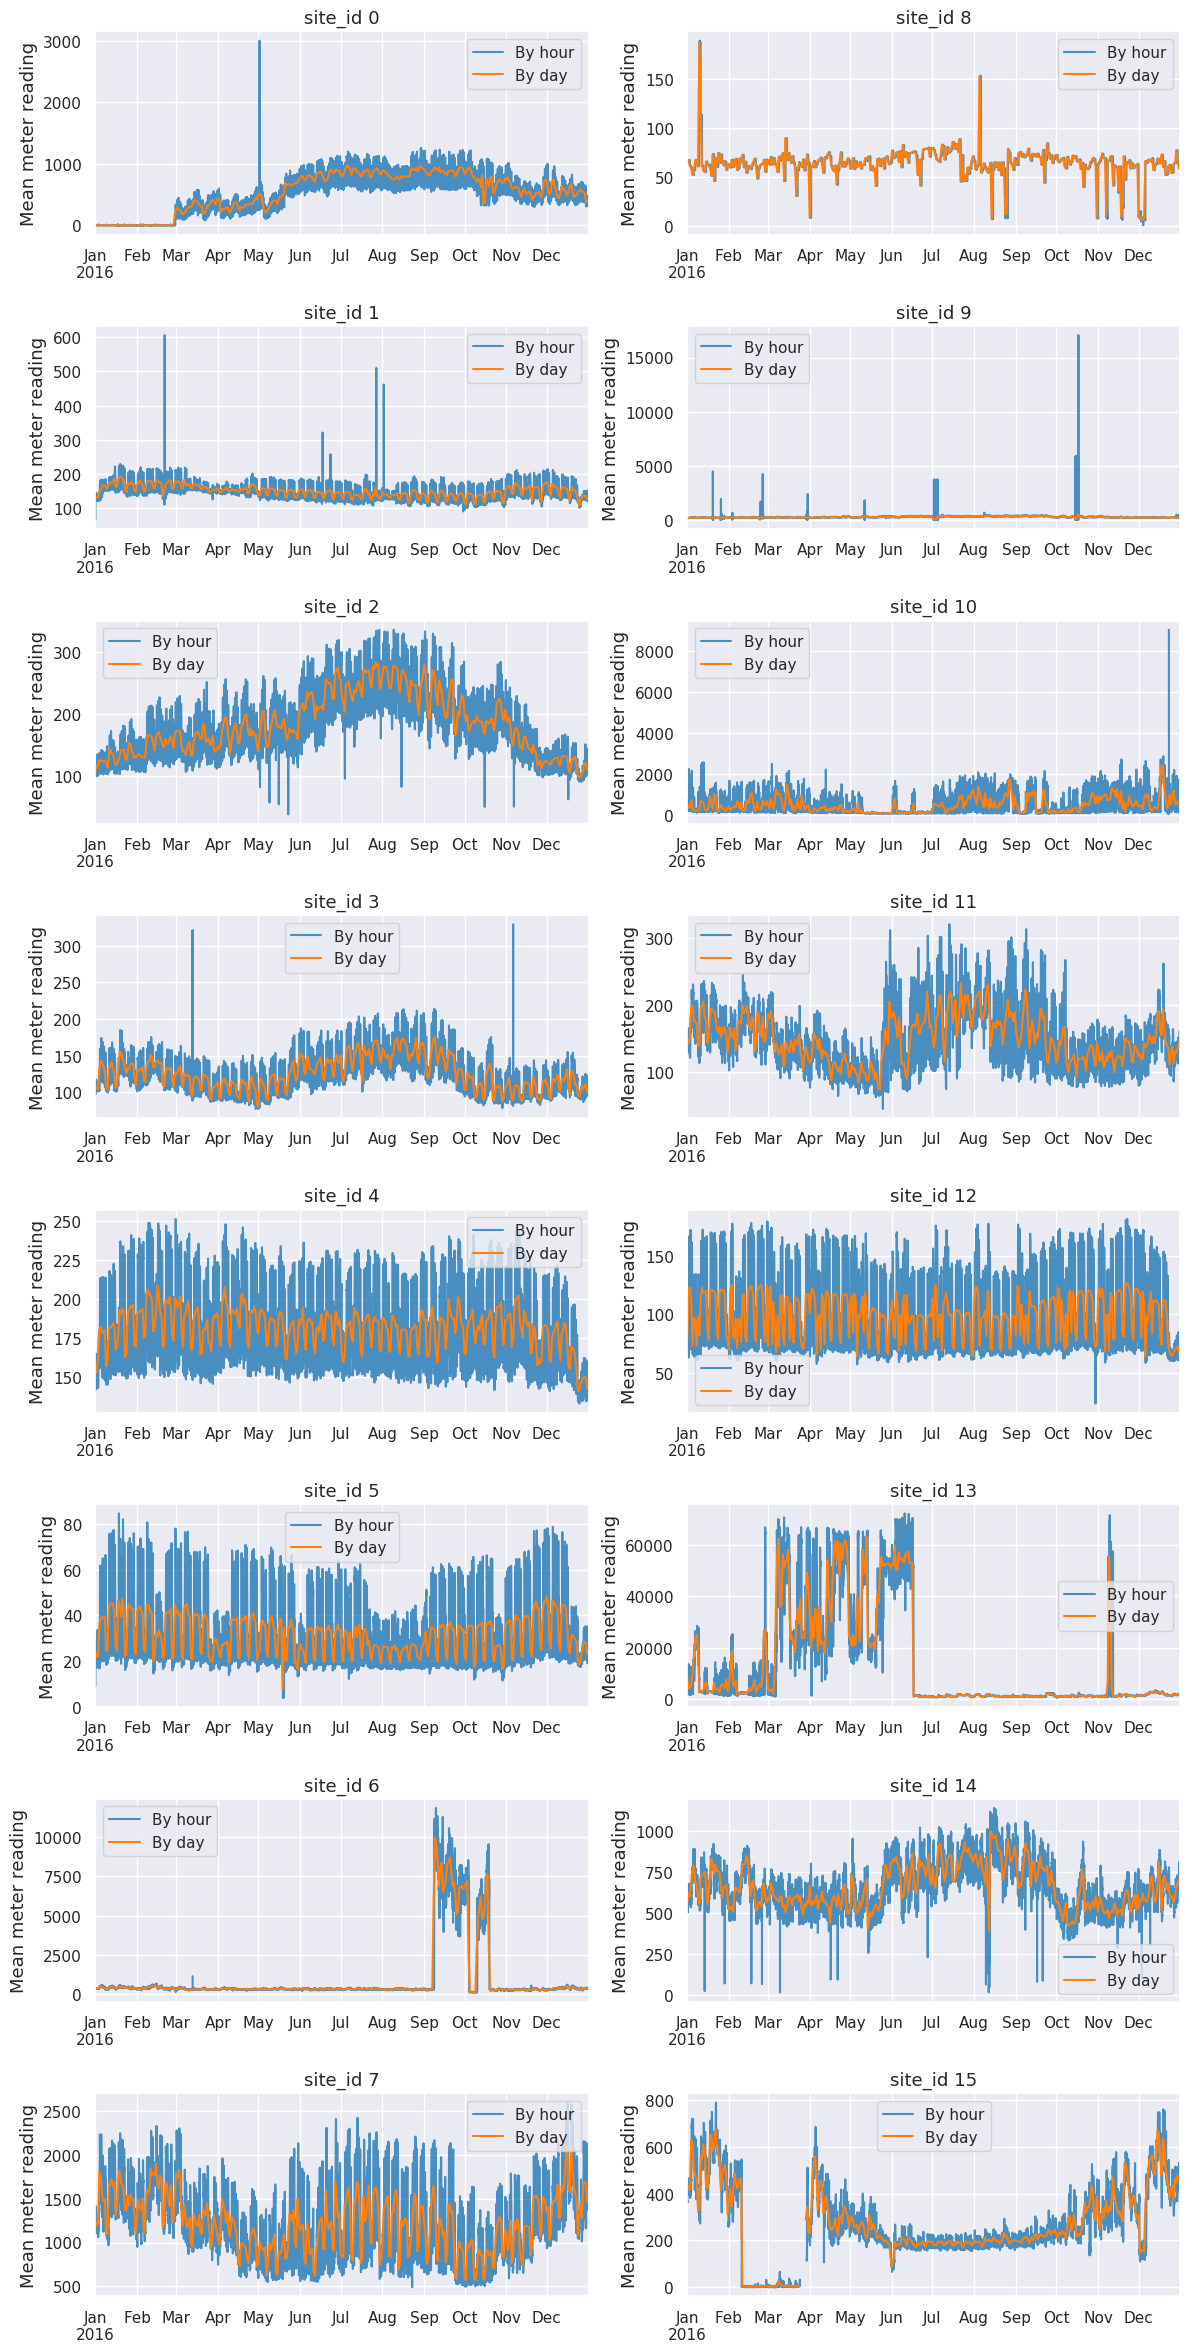

In [7]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

So what do we see here?

* First of all, as it was already discussed, site_id 0 starts from March. Until that time all measurements are 0's. Maybe buildings in that area were under construction? As a conclusion - we don't need al the data for this particular site_id before that date.

* site_id 13 looks a lot like the overall mean meter_reading, isn't it? Lets take even a closer look.

### Mean meter reading by primary_use for site_id==13

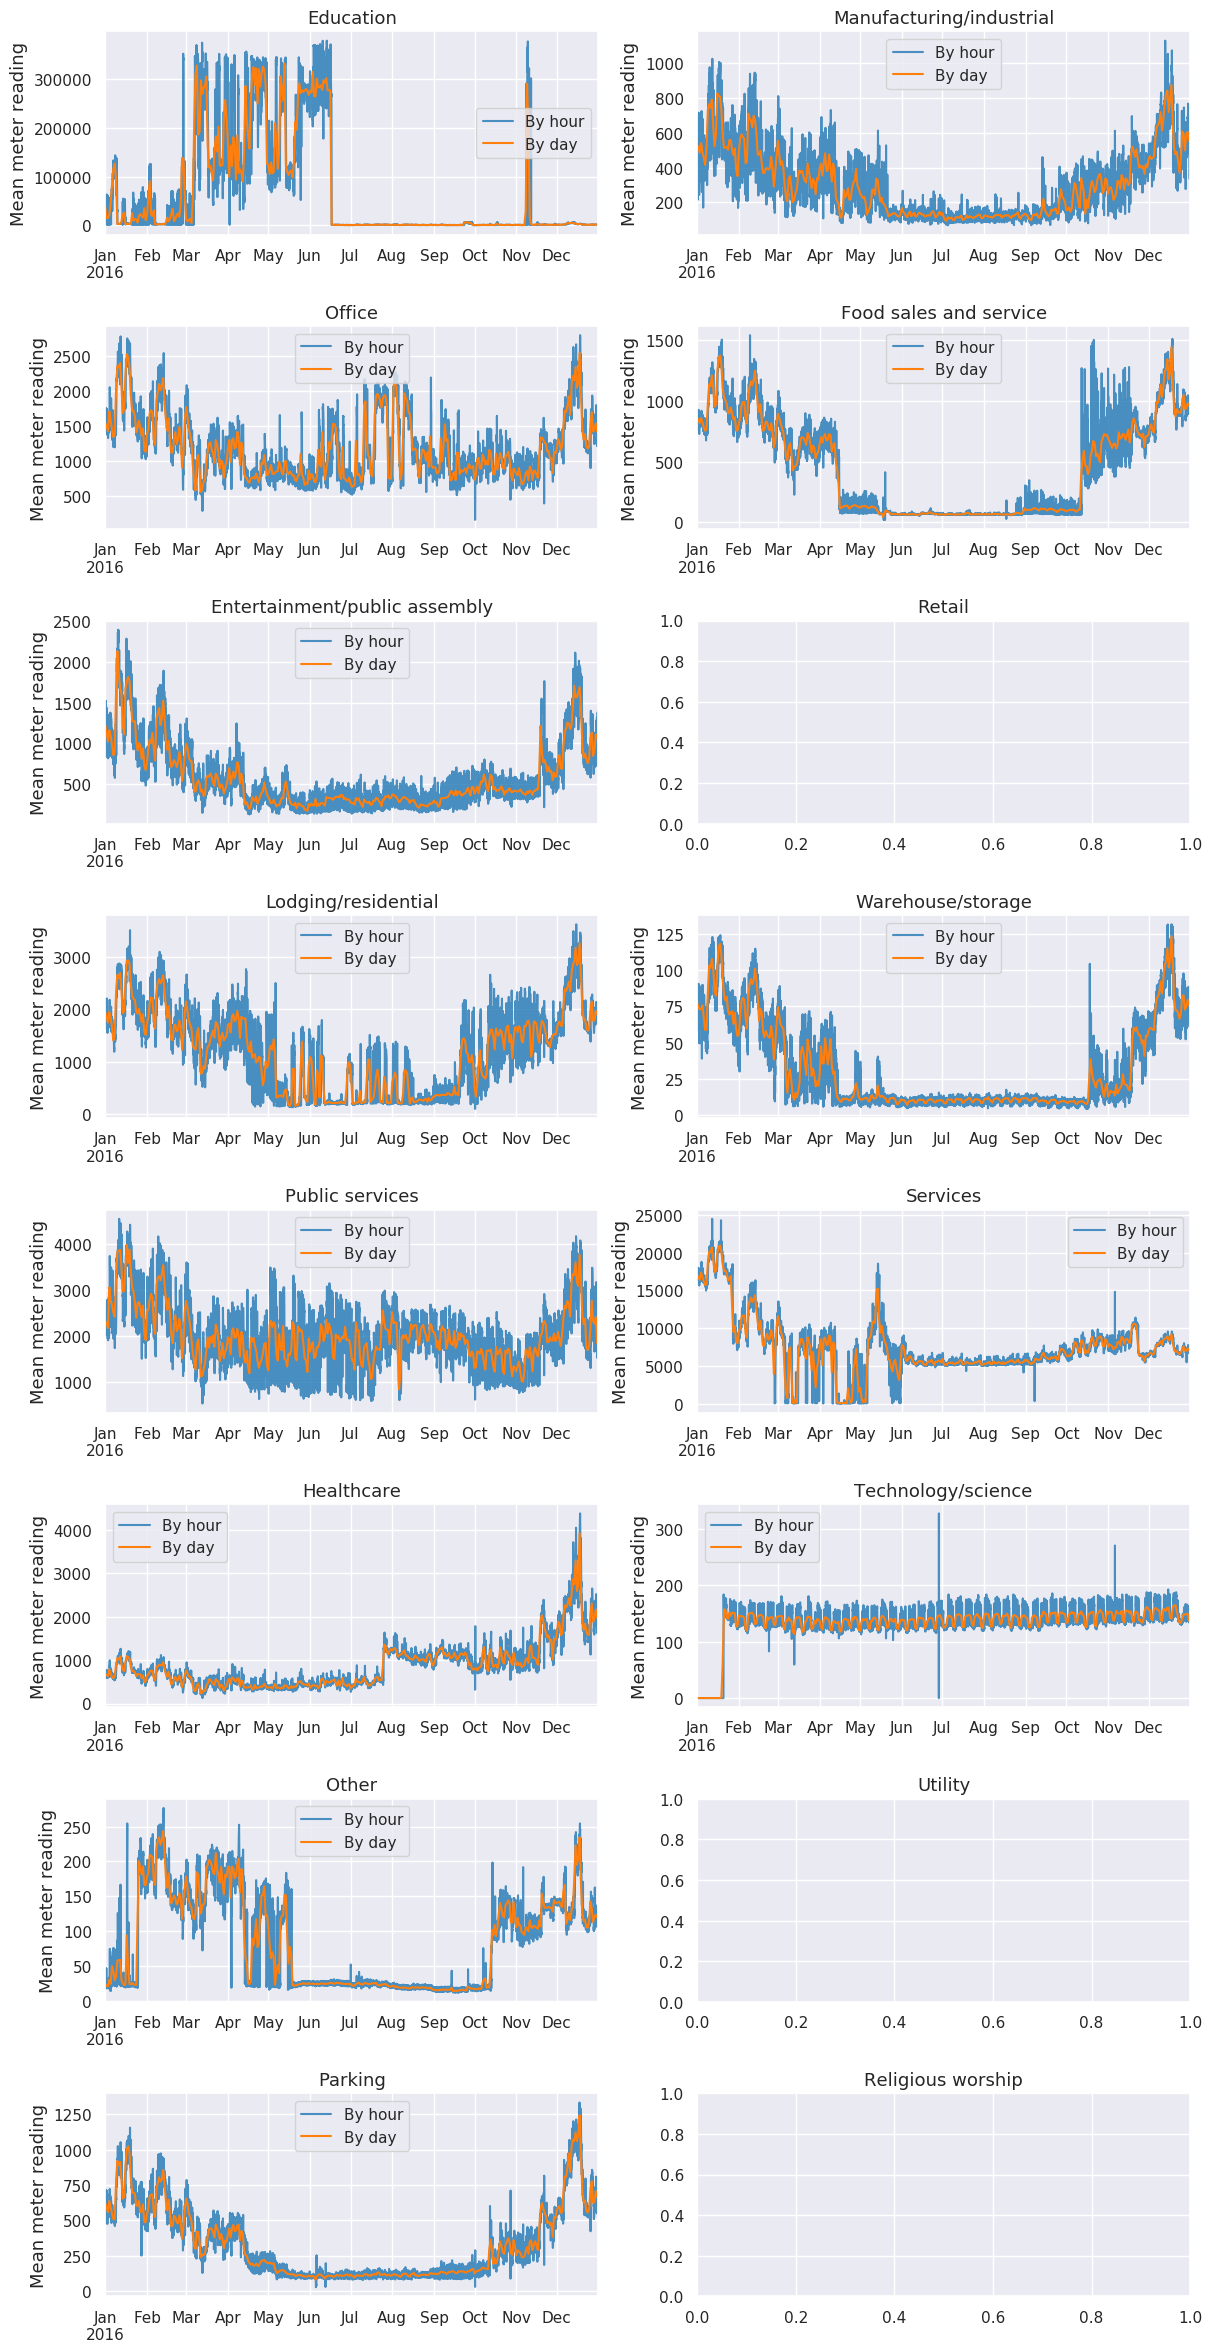

In [8]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i, use in enumerate(train['primary_use'].value_counts().index.to_list()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

One more level of conclusions:
* site_id == 13 and primary_use == Education looks a lot like a general mean for meter reading. So it is really invest a lost into the whole data
* site_id == 13 and primary_use == Technology/Science also have 0's in meter readings in January. Just like site_id 0, that we found earlier.

Lets keep digging and see what meter type is responsible for such weird look of the meter reading for site_id 13 and primary_use Education.

### Mean meter reading by meter type for primary_use==Education and site_id==13

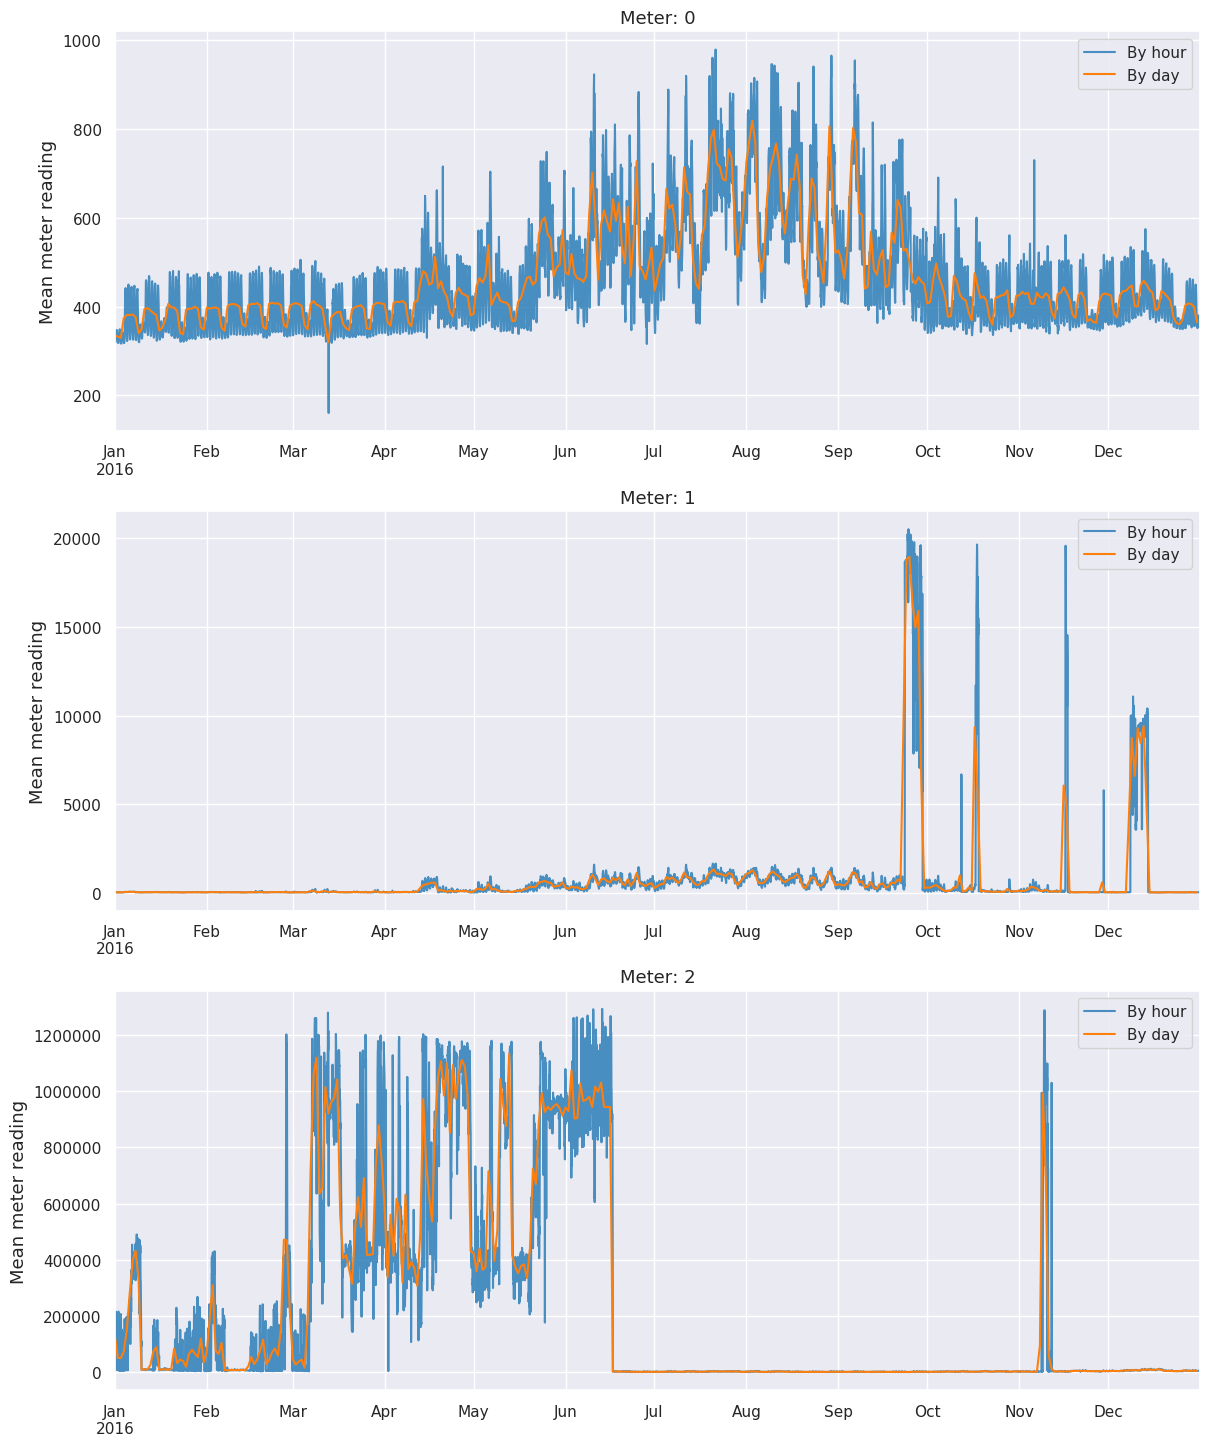

In [9]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

Fine. What we have right now is that site_id 13 with primary_use Education and meter type 2 is responsible for this mess. 

But we need to go deeper. There are 17 buildings that fall under these criteria. No problem. Another plot.

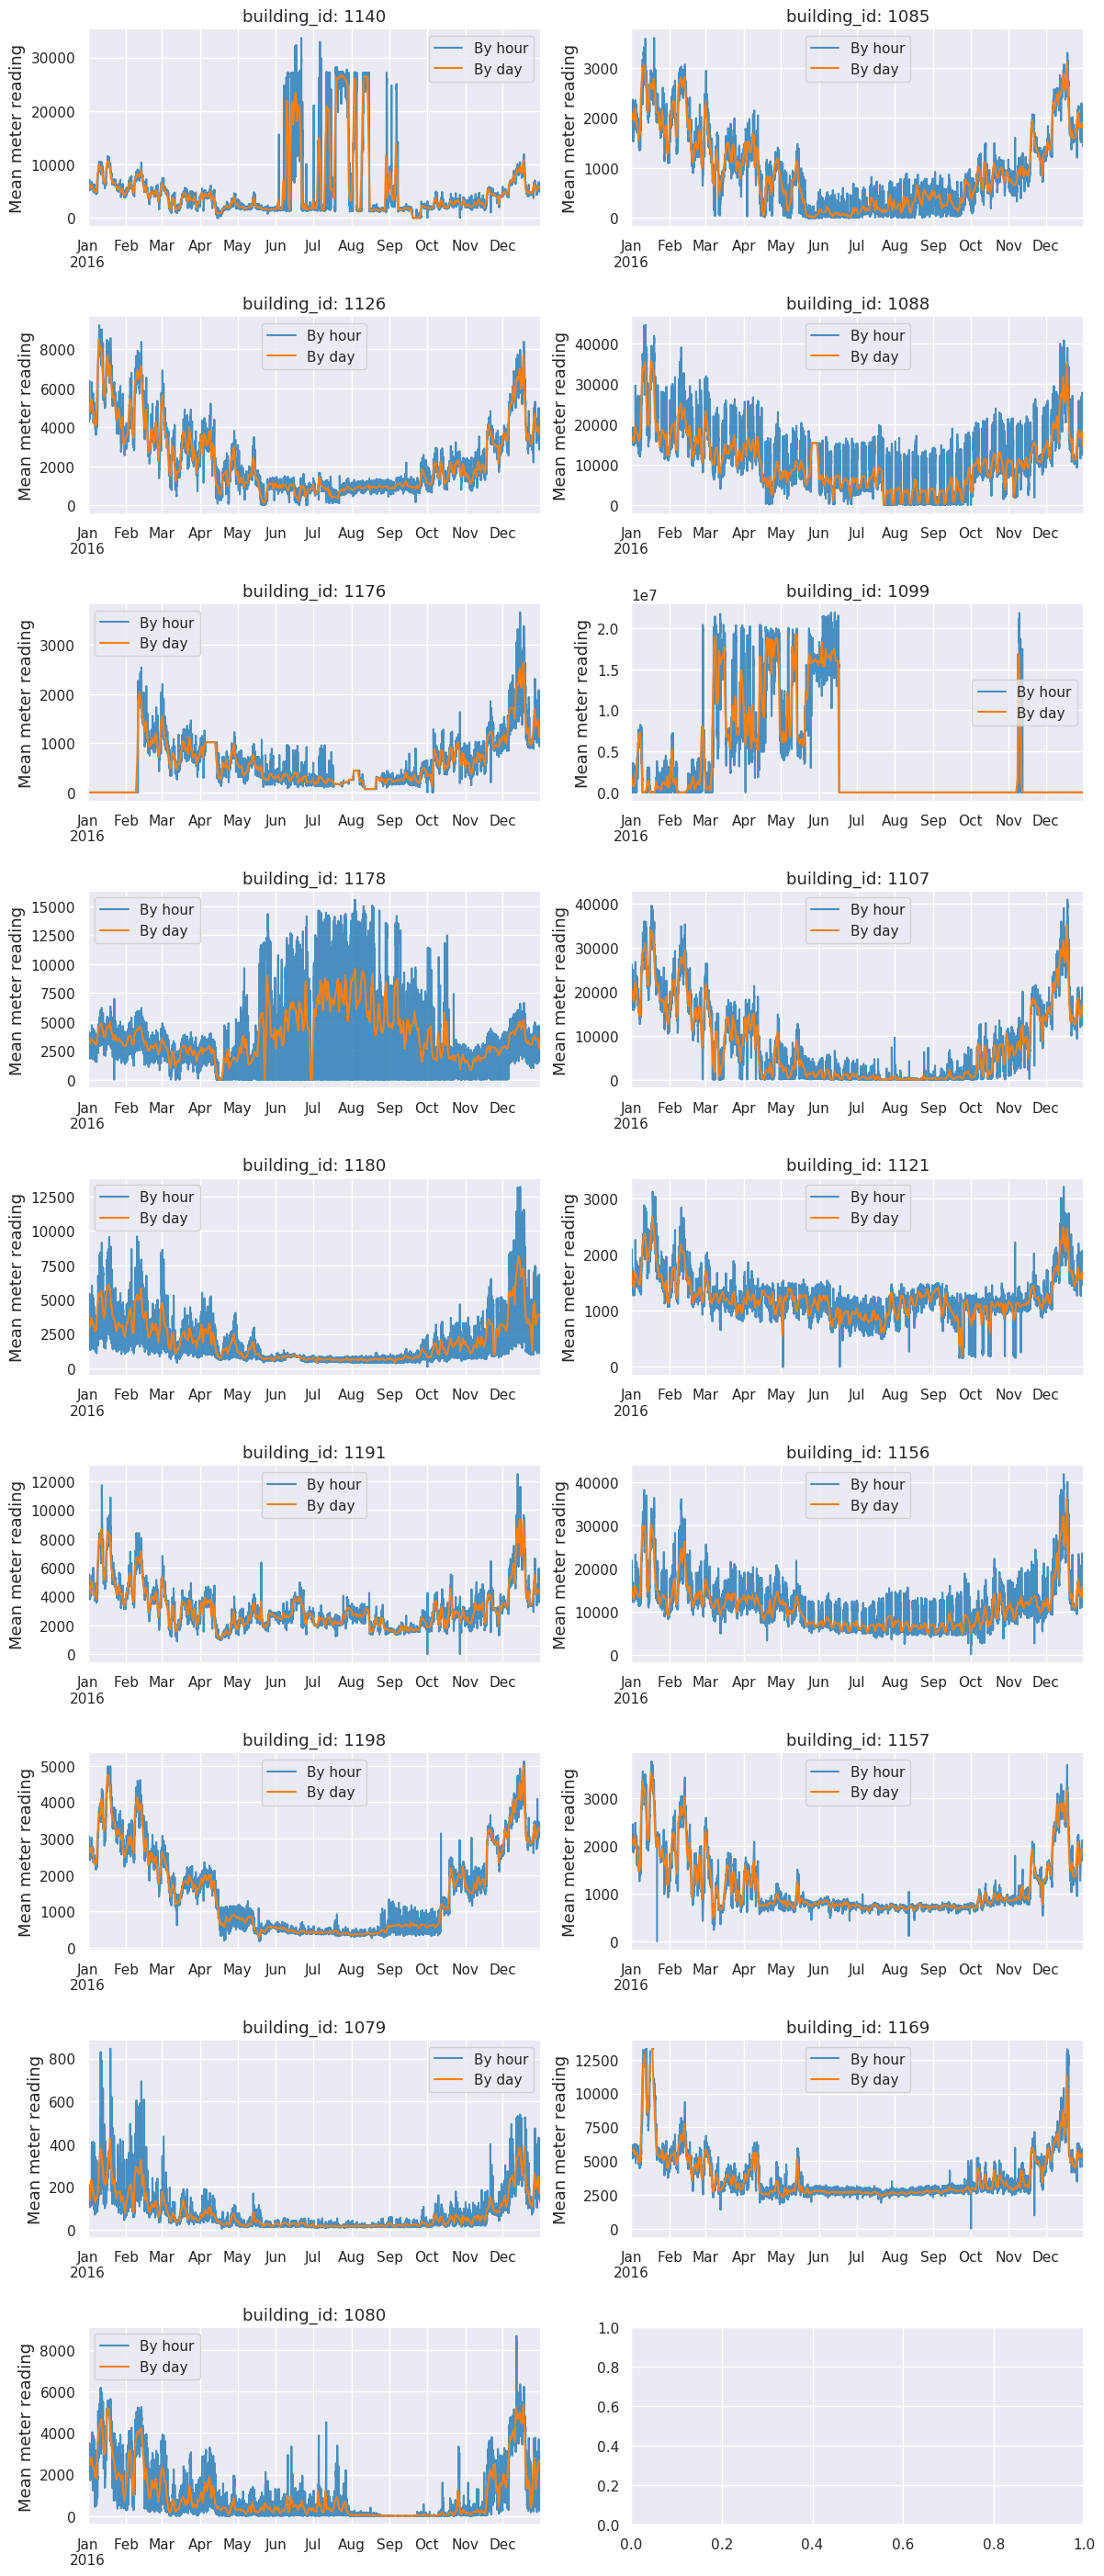

In [10]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
for i, building in enumerate(train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2)]['building_id'].value_counts(dropna=False).index.to_list()):
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

And we have a winner. It is a building_id == 1099 (we are going to see that guy a little later again). Now lets plot it side by side with a mean meter reading for all dataset. And also see what this plot would look like if we exclude building_id 1099 from the data.

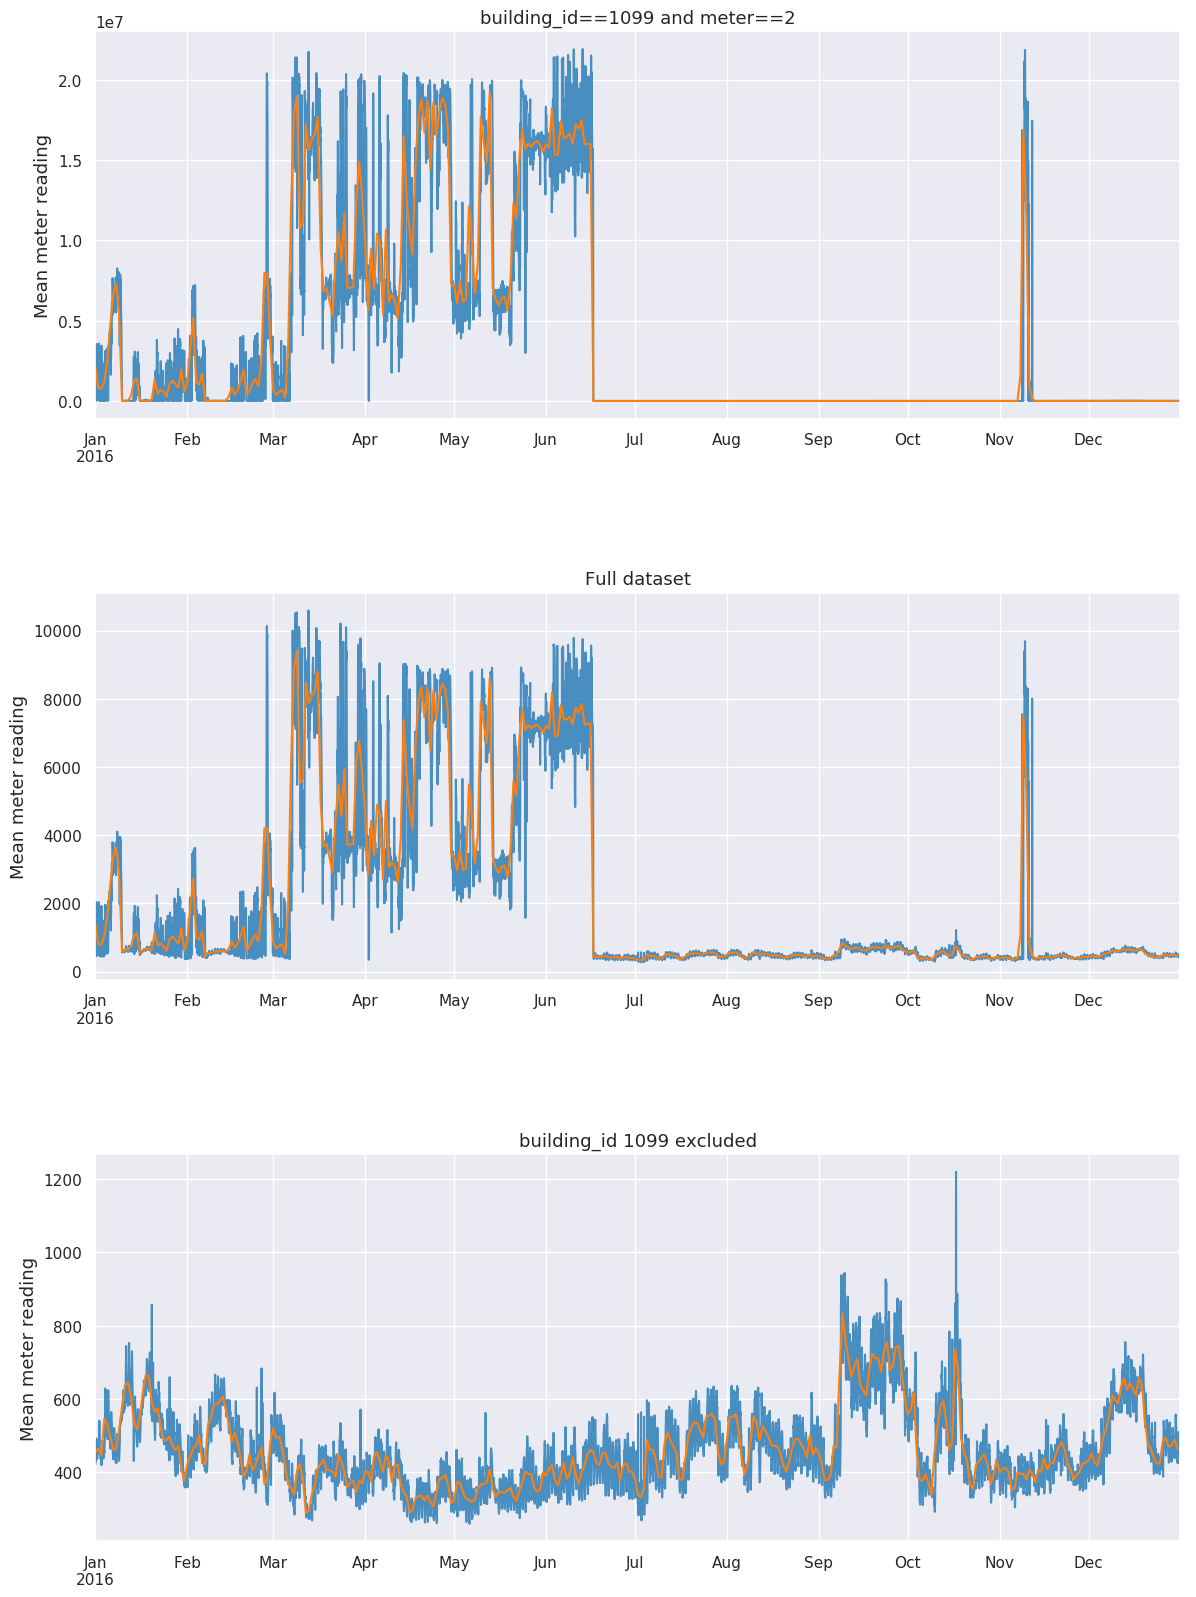

In [11]:
fig, axes = plt.subplots(3,1,figsize=(14, 20), dpi=100)

train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[0], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[2], alpha=1, label='By day', color='tab:orange').set_xlabel('');

axes[0].set_title('building_id==1099 and meter==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('building_id 1099 excluded', fontsize=13);
plt.subplots_adjust(hspace=0.45)

<a id="3"></a>
# Number of observations by day

This is something interesting. We can see that number of observations by day in testing dataset is always the same. But not in the training set.

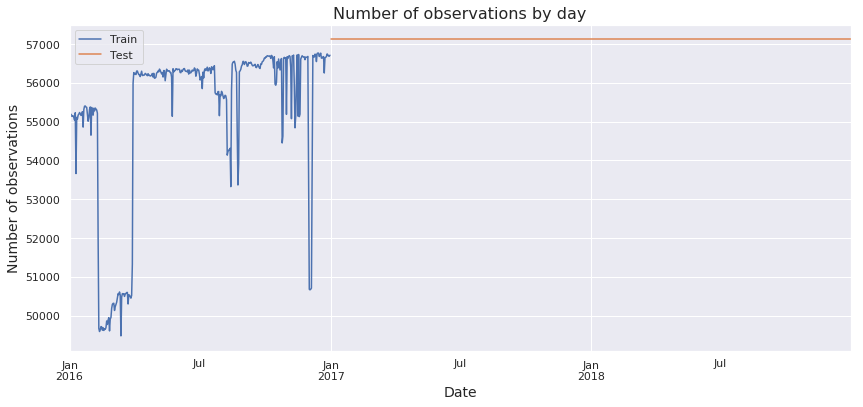

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

<a id="meter"></a>
# Meter

meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter type

Looks like steam is the most unefficient way of heating things up.

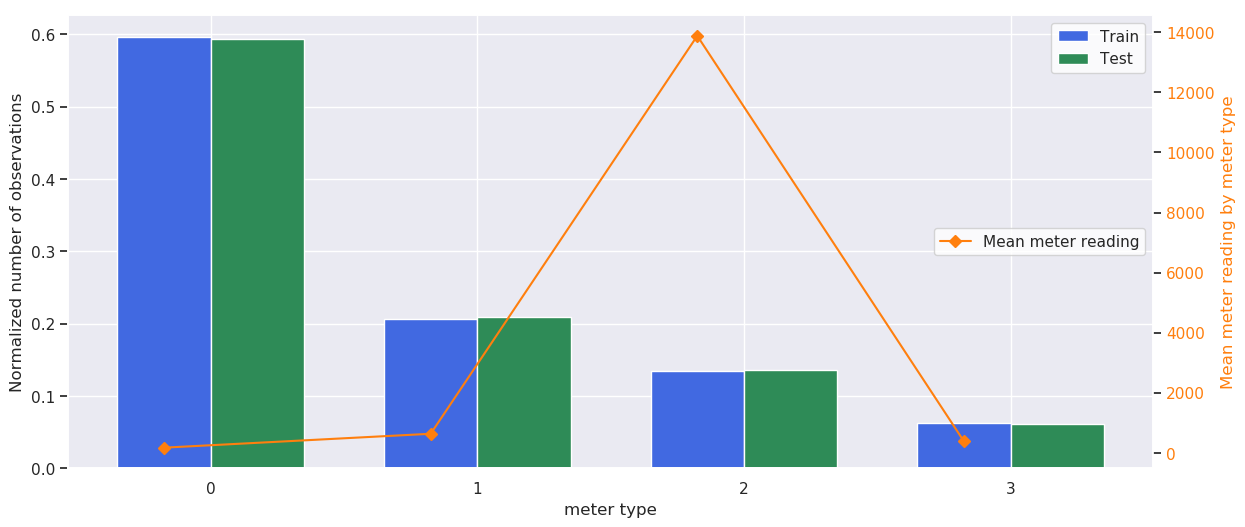

In [13]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

### Box plot of meter reading by meter type with outliers removed

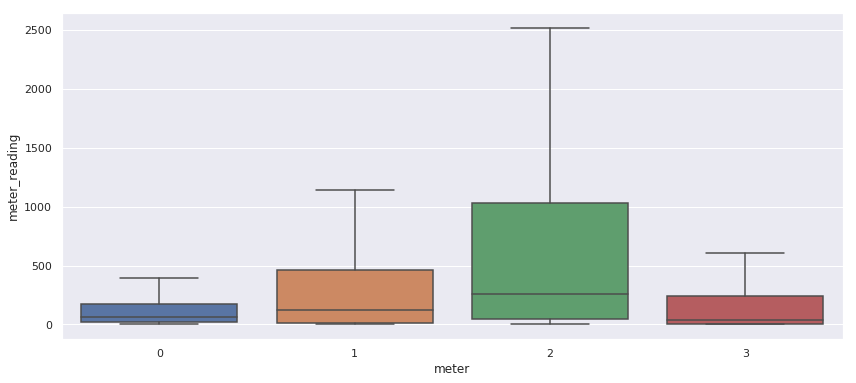

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

### Box plot of air temperature by meter type

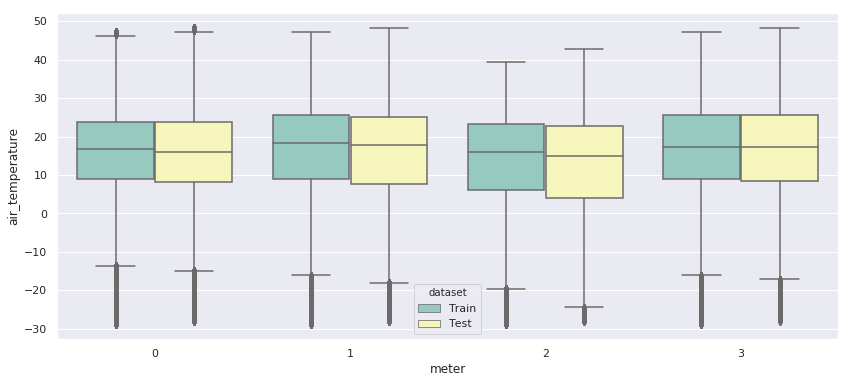

In [15]:
tmp_df = pd.concat([train[['meter', 'air_temperature']], test[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

<a id="site_id"></a>
# site_id

site_id - Foreign key for the weather files.

In my understanding this is a location.

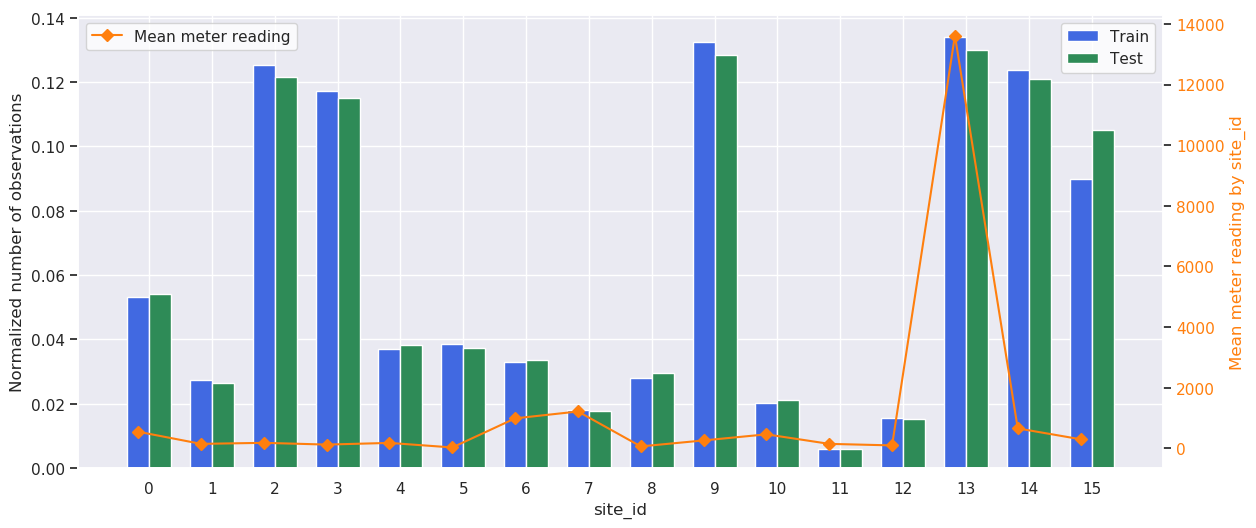

In [16]:
train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### Box plot of meter reading by site_id with outliers removed

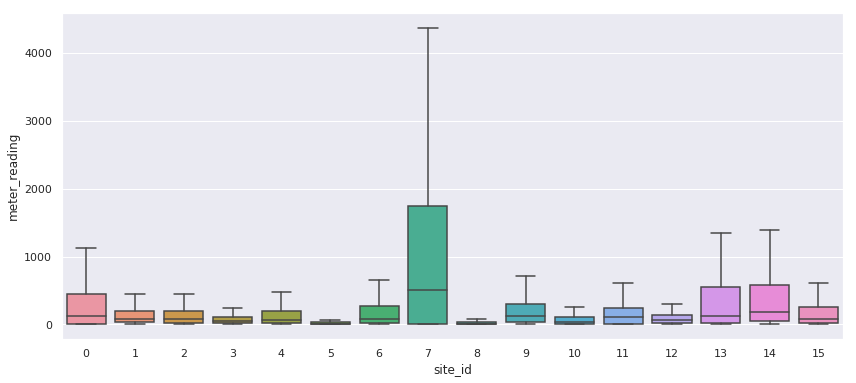

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

### Box plot of air temperature by site_id

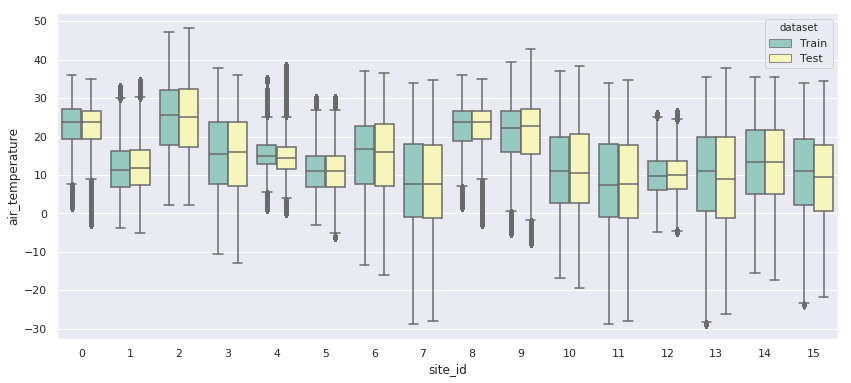

In [18]:
tmp_df = pd.concat([train[['site_id', 'air_temperature']], test[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

<a id="primary_use"></a>
# primary_use

primary_use - Indicator of the primary category of activities for the building based on [EnergyStar property type definitions](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type)

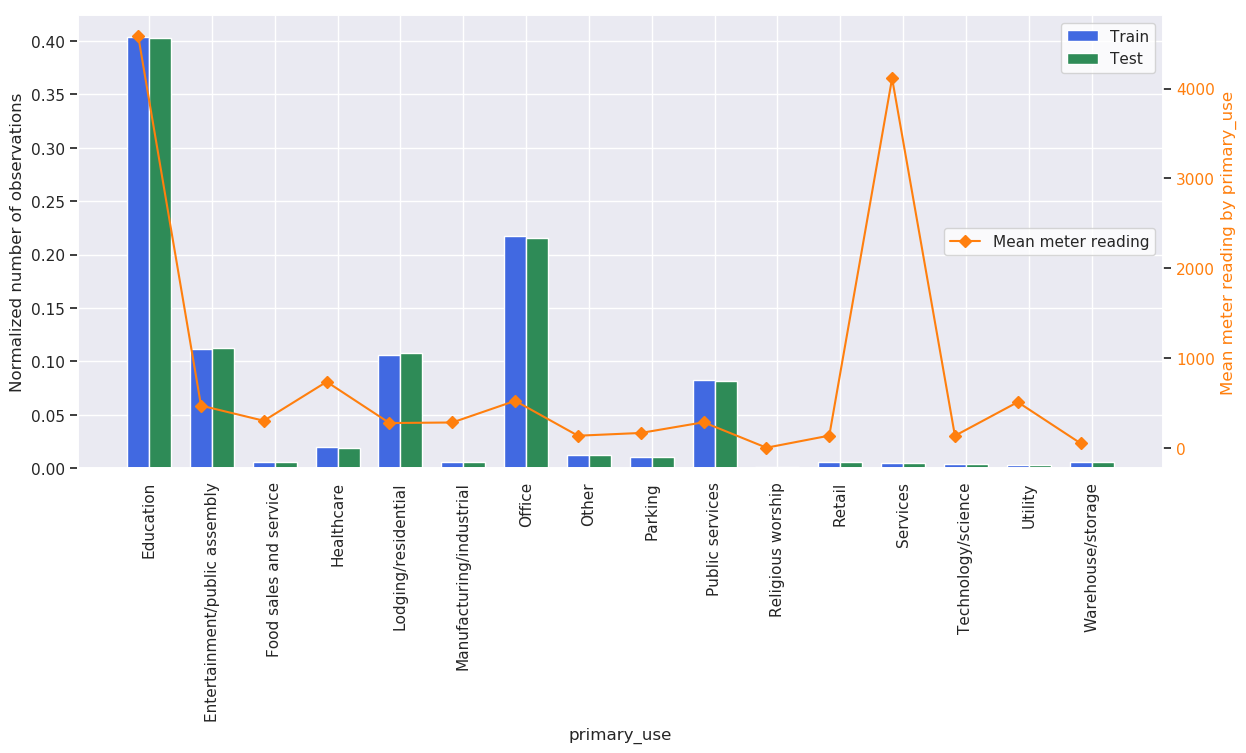

In [19]:
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

<a id="square_feet"></a>
# square_feet

square_feet - Gross floor area of the building

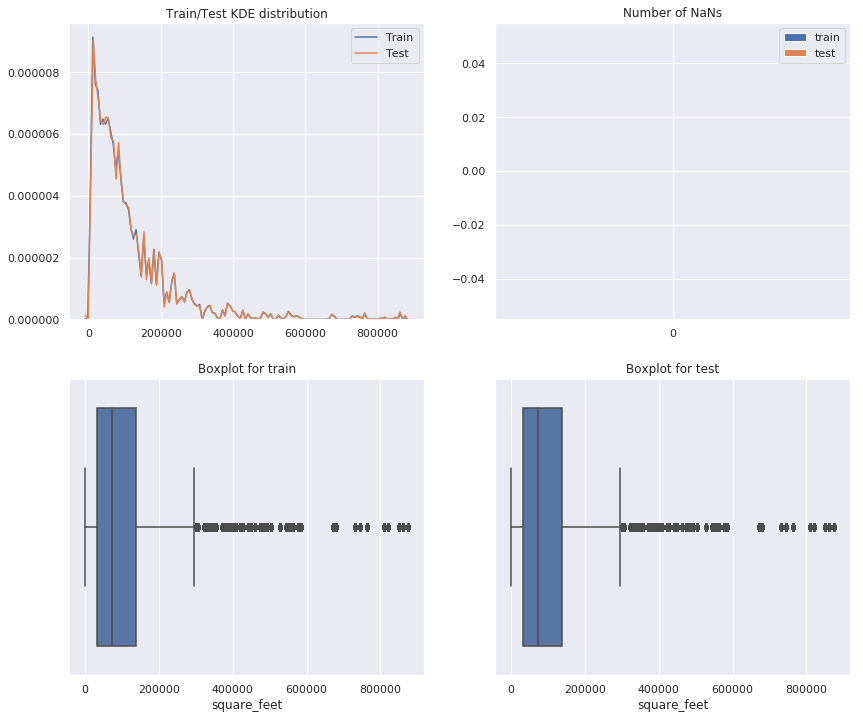

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

square_feet is 100% the same as building_id. I am going to show that. Every building_id has only one unique value.

Which makes sence - building_id is a unique building identifier and each building can have only one possible value of square_feet. Also year_built is going to be the same per unique building_id. Just keep that in mind.

In [21]:
print(train[train['building_id'] == 0]['square_feet'].value_counts())
print(train[train['building_id'] == 1]['square_feet'].value_counts())
print(train[train['building_id'] == 100]['square_feet'].value_counts())

7432    8784
Name: square_feet, dtype: int64
2720    8784
Name: square_feet, dtype: int64
24456    8784
Name: square_feet, dtype: int64


In [22]:
train[['building_id', 'square_feet']].sort_index(by='building_id')

building_id  square_feet
0                   0         7432
4232656             0         7432
11161913            0         7432
13433842            0         7432
15695236            0         7432
...               ...          ...
17664532         1448        92271
7917878          1448        92271
7920222          1448        92271
7908496          1448        92271
20216099         1448        92271

[20216100 rows x 2 columns]

Lets take a look at the mean meter reading by building_id.

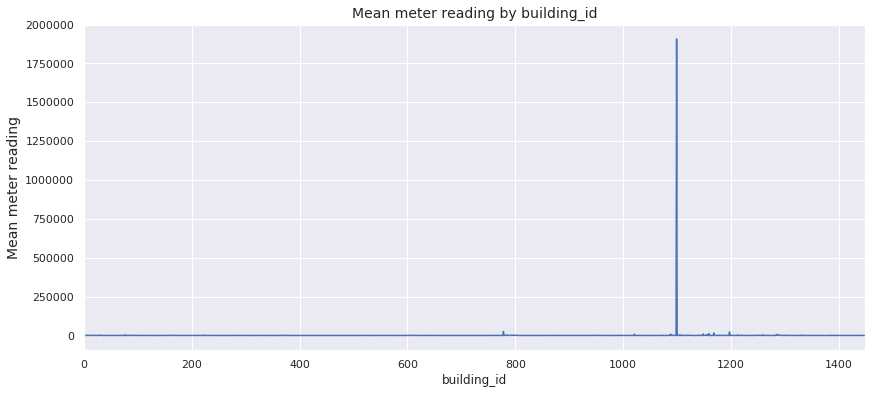

In [23]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

There is an obvious outlier in data. Lets see what it is.

Well, it is an educational building with no year_build or floor_count provided, so probably it is an old one.

They have a steam meter which measures such an outstanding amount of electricity used. 

It seems to me that this is a really really old school with a steam heating. 

In [24]:
train[(train['building_id']==1099) & (train['meter_reading'] > 3000000)]

building_id  meter           timestamp  meter_reading  site_id  \
1534             1099      2 2016-01-01 00:00:00      3241630.0       13   
3830             1099      2 2016-01-01 01:00:00      3241630.0       13   
22191            1099      2 2016-01-01 09:00:00      3554740.0       13   
24488            1099      2 2016-01-01 10:00:00      3341210.0       13   
38275            1099      2 2016-01-01 16:00:00      3009500.0       13   
...               ...    ...                 ...            ...      ...   
17345482         1099      2 2016-11-10 15:00:00     15008300.0       13   
17347844         1099      2 2016-11-10 16:00:00      5399540.0       13   
17350207         1099      2 2016-11-10 17:00:00     10357700.0       13   
17352570         1099      2 2016-11-10 18:00:00     12274400.0       13   
17420378         1099      2 2016-11-11 23:00:00     17447600.0       13   

         primary_use  square_feet  year_built  floor_count  air_temperature  \
1534       Education       332884         NaN          NaN             -8.3   
3830       Education       332884         NaN          NaN             -8.3   
22191      Education       332884         NaN          NaN             -6.7   
24488      Education       332884         NaN          NaN             -8.3   
38275      Education       332884         NaN          NaN             -6.7   
...              ...          ...         ...          ...              ...   
17345482   Education       332884         NaN          NaN              9.4   
17347844   Education       332884         NaN          NaN             11.7   
17350207   Education       332884         NaN          NaN             13.9   
17352570   Education       332884         NaN          NaN             16.1   
17420378   Education       332884         NaN          NaN              7.8   

          cloud_coverage  dew_temperature  precip_depth_1_hr  \
1534                 8.0            -12.2                NaN   
3830                 NaN            -11.7               -1.0   
22191                NaN             -9.4               -1.0   
24488                NaN            -11.7                0.0   
38275                NaN            -10.6                0.0   
...                  ...              ...                ...   
17345482             0.0              2.8                0.0   
17347844             0.0              3.3                0.0   
17350207             0.0              3.3                0.0   
17352570             0.0              4.4                0.0   
17420378             0.0             -3.3                0.0   

          sea_level_pressure  wind_direction  wind_speed  
1534             1023.299988           250.0         4.1  
3830             1023.299988           240.0         4.1  
22191            1022.000000           250.0         3.6  
24488            1021.900024           270.0         6.7  
38275            1017.900024           230.0         6.2  
...                      ...             ...         ...  
17345482         1013.799988           230.0         4.6  
17347844         1013.500000           250.0         4.6  
17350207         1013.700012           270.0         5.1  
17352570         1013.299988           270.0         4.6  
17420378         1032.099976             0.0         0.0  

[2746 rows x 16 columns]

Also there is one more interesting thing, that I want to check. This building is located at site_id 13. So maybe this is some old area? Or this building is the only one consuming so much in the neighbourhood?

So I have decided to plot mean energy consumption by site_id WITH and WITHOUT this particular building included. And this is what it looks like.

Pay attention - the 'Mean meter reading' scale has changed by a factor of 10. So this is the only building with such an enormoush measurements.

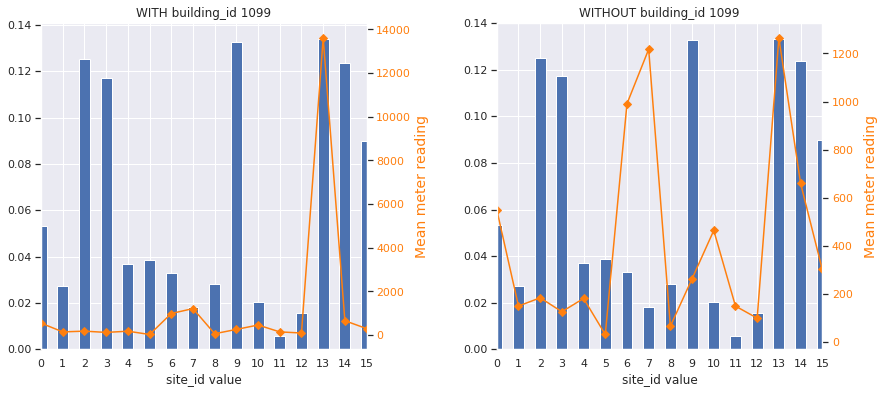

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train[train['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train[train['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

Mean meter reading by building_id WITHOUT building_id 1099

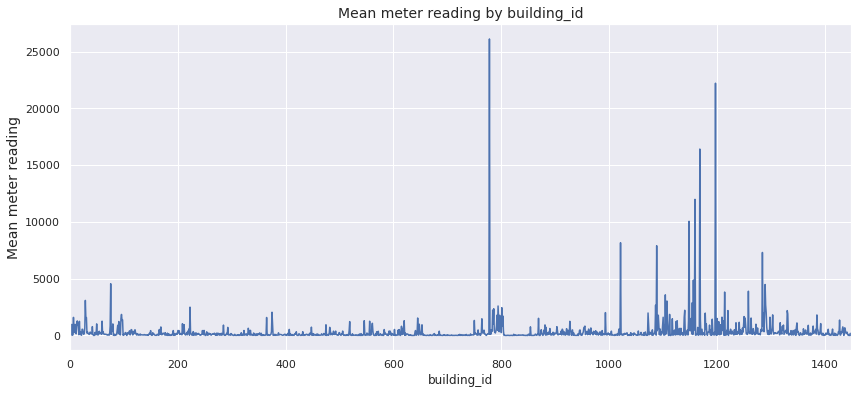

In [26]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

<a id="year_built"></a>
# year_built

year_built - Year building was opened

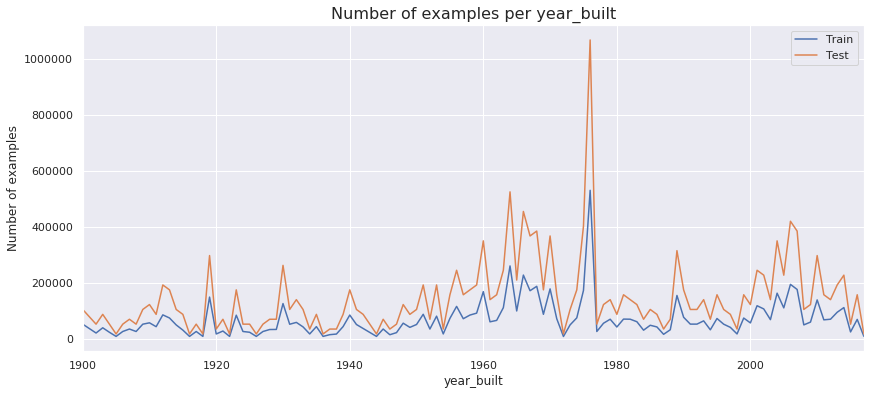

In [27]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('year_built');
test['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_ylabel('Number of examples');
axes.legend(['Train', 'Test']);
axes.set_title('Number of examples per year_built', fontsize=16);

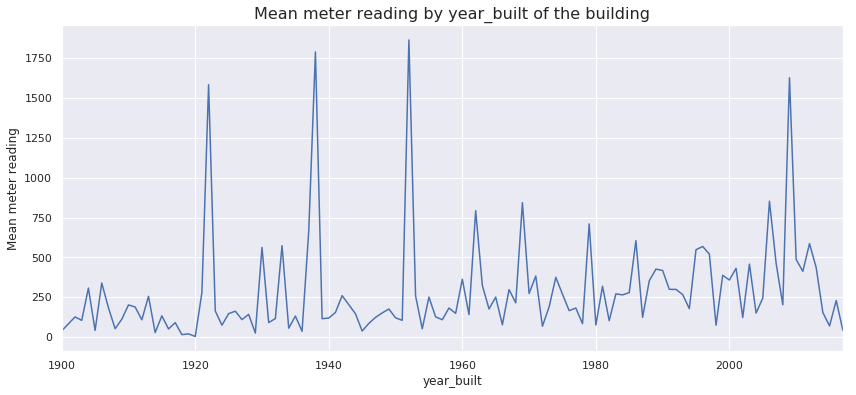

In [28]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

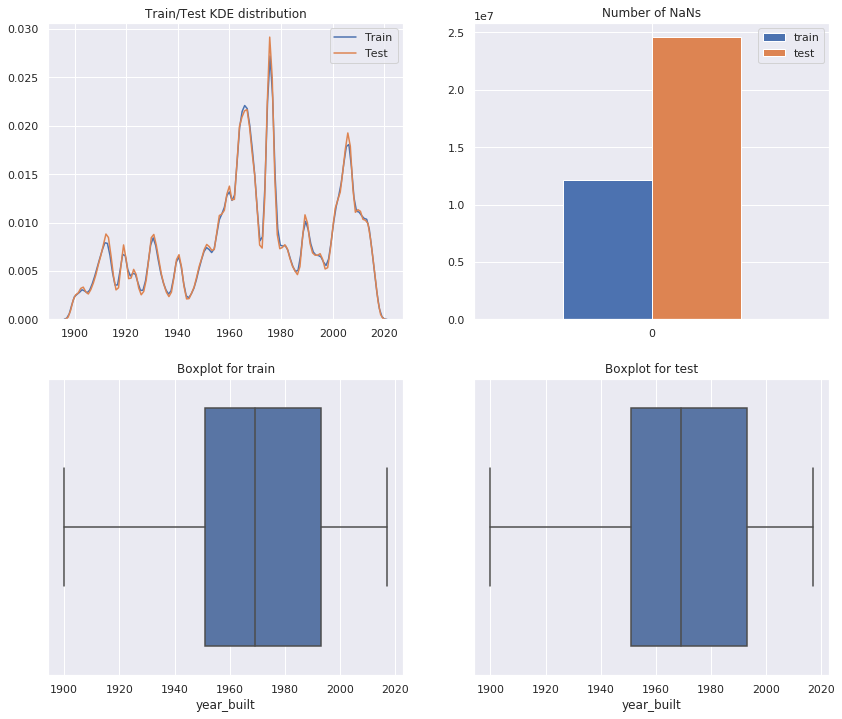

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test['year_built'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['year_built'], ax=axes[1][0]);
sns.boxplot(x=test['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train['year_built'].isnull().sum()], 'test': [test['year_built'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

<a id="floor_count"></a>
# floor_count

floor_count - Number of floors of the building

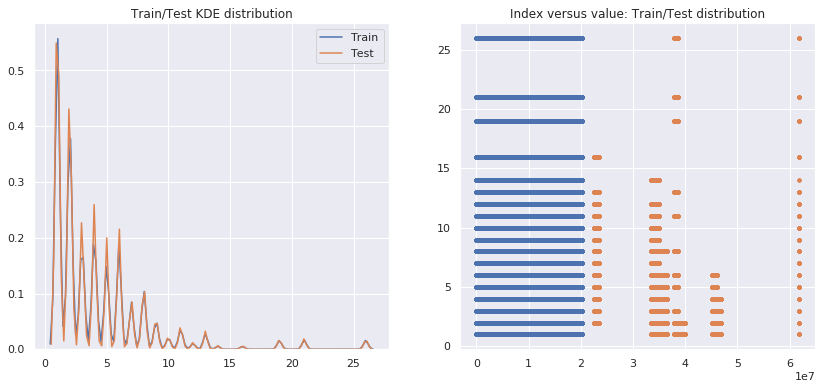

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(train['floor_count'], label='Train', ax=axes[0]);
sns.kdeplot(test['floor_count'], label='Test', ax=axes[0]);
test.index += len(train)
axes[1].plot(train['floor_count'], '.', label='Train');
axes[1].plot(test['floor_count'], '.', label='Test');
test.index -= len(train)
axes[0].set_title('Train/Test KDE distribution');
axes[1].set_title('Index versus value: Train/Test distribution');
gc.collect();

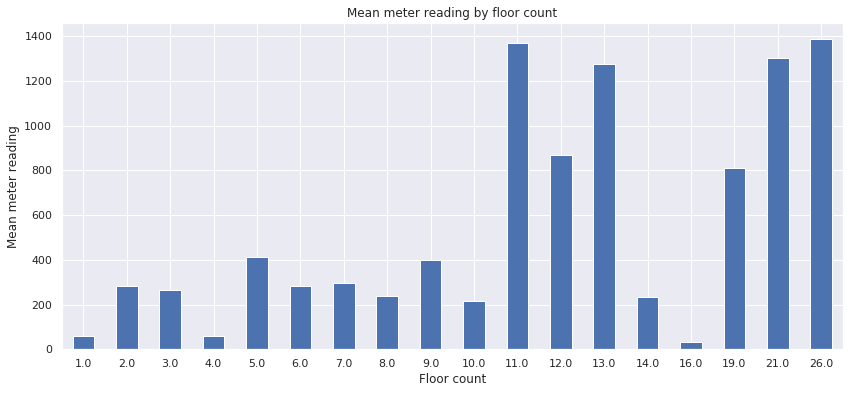

In [31]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
pd.Series(index=train['floor_count'].value_counts().index, 
          data=train.groupby('floor_count')['meter_reading'].transform('mean').value_counts().index).sort_index().plot(kind='bar', rot=0, ax=axes);
axes.set_xlabel('Floor count');
axes.set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by floor count');

### Number of NaNs in floor_count

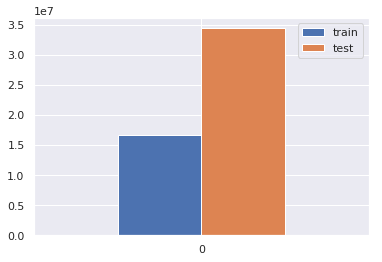

In [32]:
pd.DataFrame({'train': [train['floor_count'].isnull().sum()], 'test': [test['floor_count'].isnull().sum()]}).plot(kind='bar', rot=0);

<a id="building_id"></a>
# building_id

building_id - Building id code

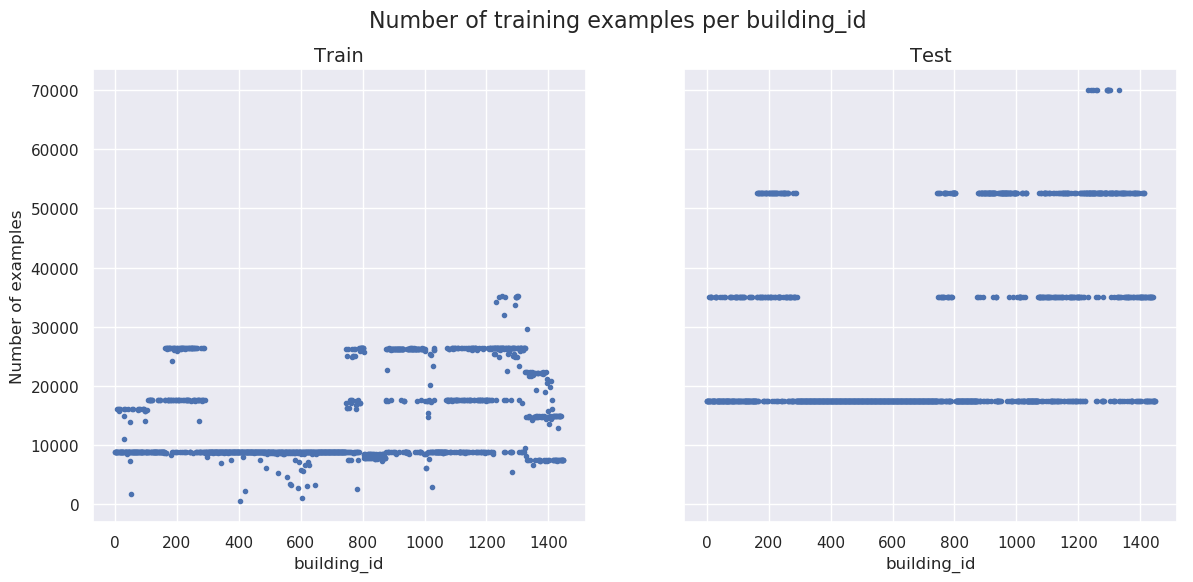

In [33]:
fig, axes = plt.subplots(1,2,figsize=(14, 6), sharey=True, dpi=100)
axes[0].plot(train['building_id'].value_counts().sort_index(), '.');
axes[1].plot(test['building_id'].value_counts().sort_index(), '.');
axes[0].set_title('Train', fontsize=14);
axes[1].set_title('Test', fontsize=14);
axes[0].set_xlabel('building_id');
axes[1].set_xlabel('building_id');
axes[0].set_ylabel('Number of examples');
fig.suptitle('Number of training examples per building_id', fontsize=16);

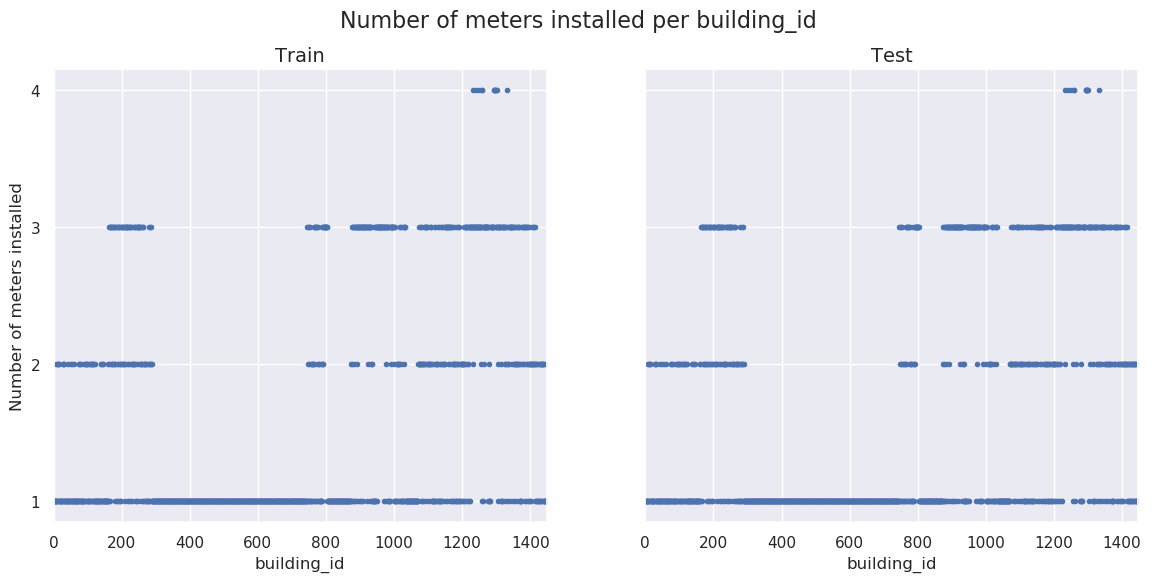

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, sharey=True)
train.groupby('building_id')['meter'].nunique().plot(style='.', ax=axes[0]);
test.groupby('building_id')['meter'].nunique().plot(style='.', ax=axes[1]);
axes[0].set_title('Train', fontsize=14);
axes[1].set_title('Test', fontsize=14);
axes[0].set_xlabel('building_id');
axes[1].set_xlabel('building_id');
axes[0].set_ylabel('Number of meters installed');
plt.yticks([1, 2, 3, 4]);
fig.suptitle('Number of meters installed per building_id', fontsize=16);

<a id="air_temperature"></a>
# air_temperature

air_temperature - Degrees Celsius

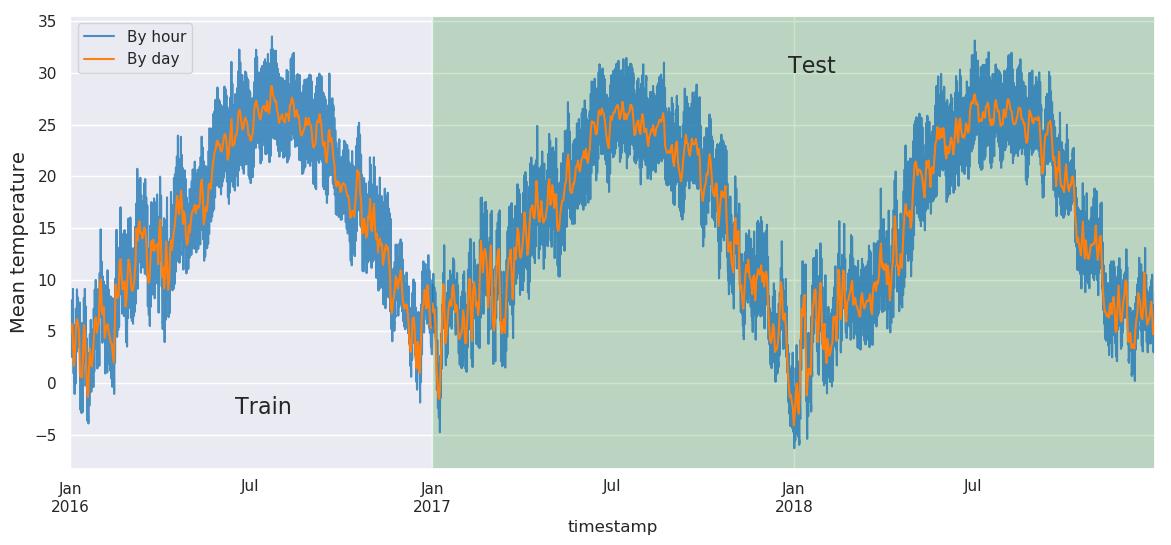

In [35]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=14);
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], -3, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[29400000], 30, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

Air temperature by site_id. Looks like some sites are more to north and some more to south.

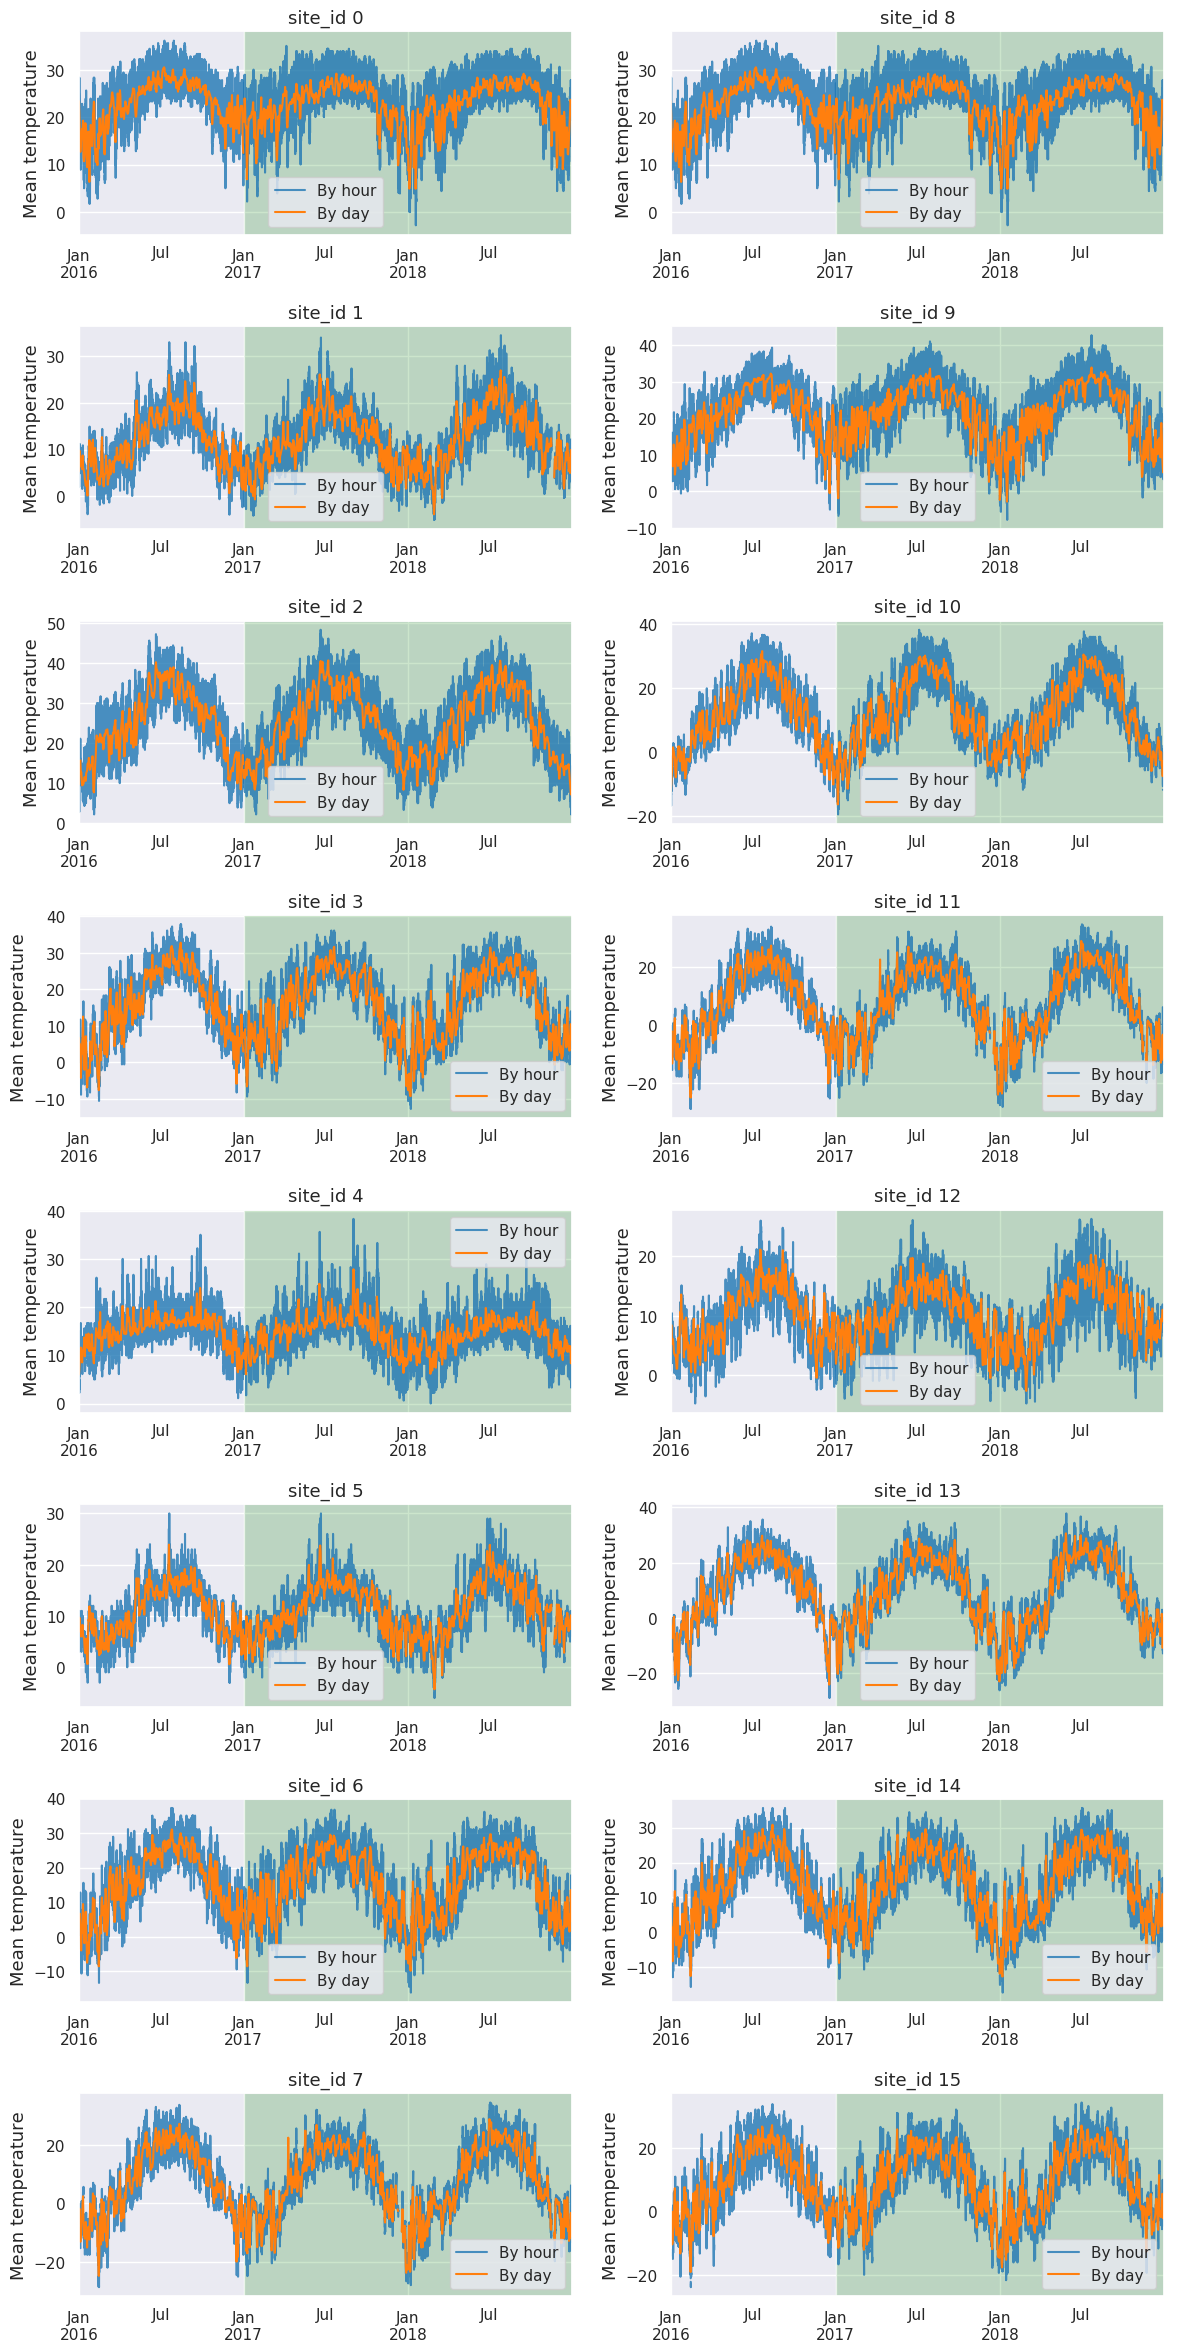

In [36]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

<a id="cloud_coverage"></a>
# cloud_coverage

cloud_coverage - Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta)

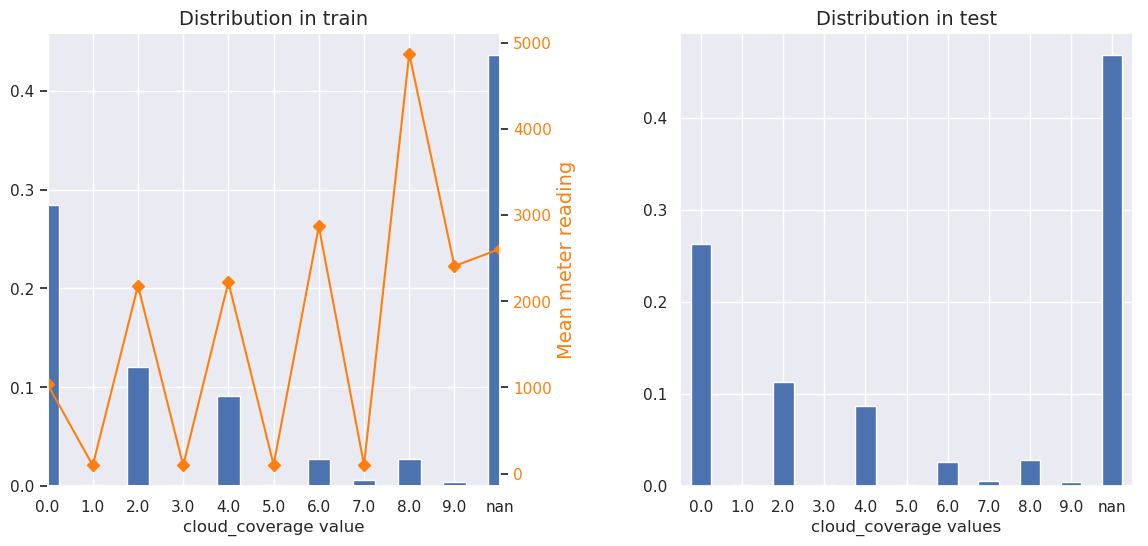

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
train['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('cloud_coverage value');
test['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('cloud_coverage values');
axes[0].set_title('Distribution in train', fontsize=14);
axes[1].set_title('Distribution in test', fontsize=14);
ax2 = axes[0].twinx()
train[['cloud_coverage', 'meter_reading']].replace(np.nan, 'nan').groupby('cloud_coverage')['meter_reading'].mean().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.set_xticklabels(train['cloud_coverage'].value_counts(dropna=False).sort_index().index)
plt.subplots_adjust(wspace=0.4);

<a id="dew_temperature"></a>
# dew_temperature

dew_temperature - Degrees Celsius

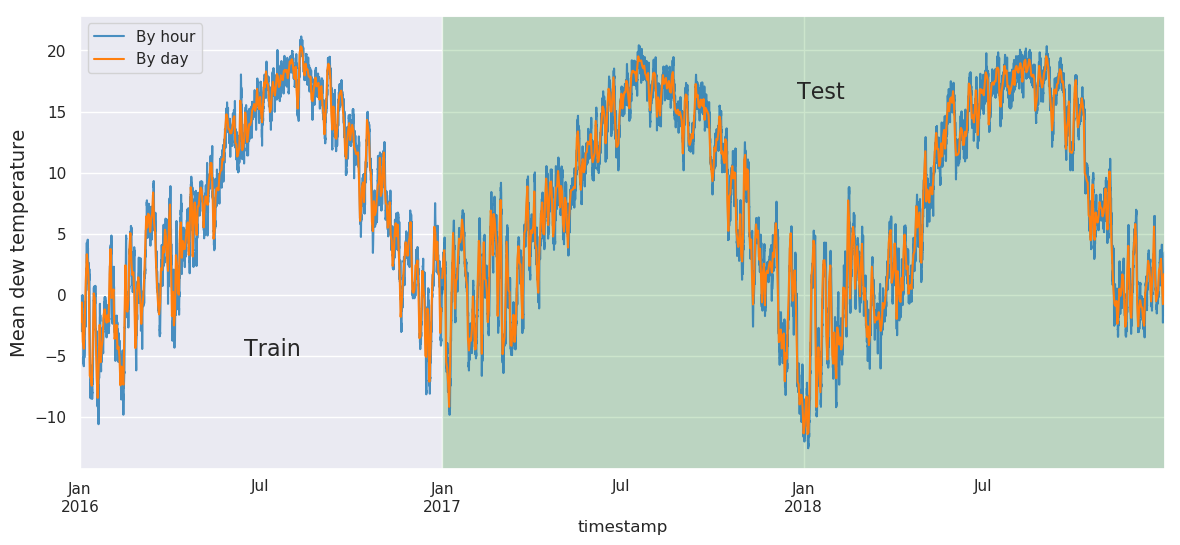

In [38]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=14);
test[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], -5, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[29400000], 16, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

Mean dew temperature by site_id

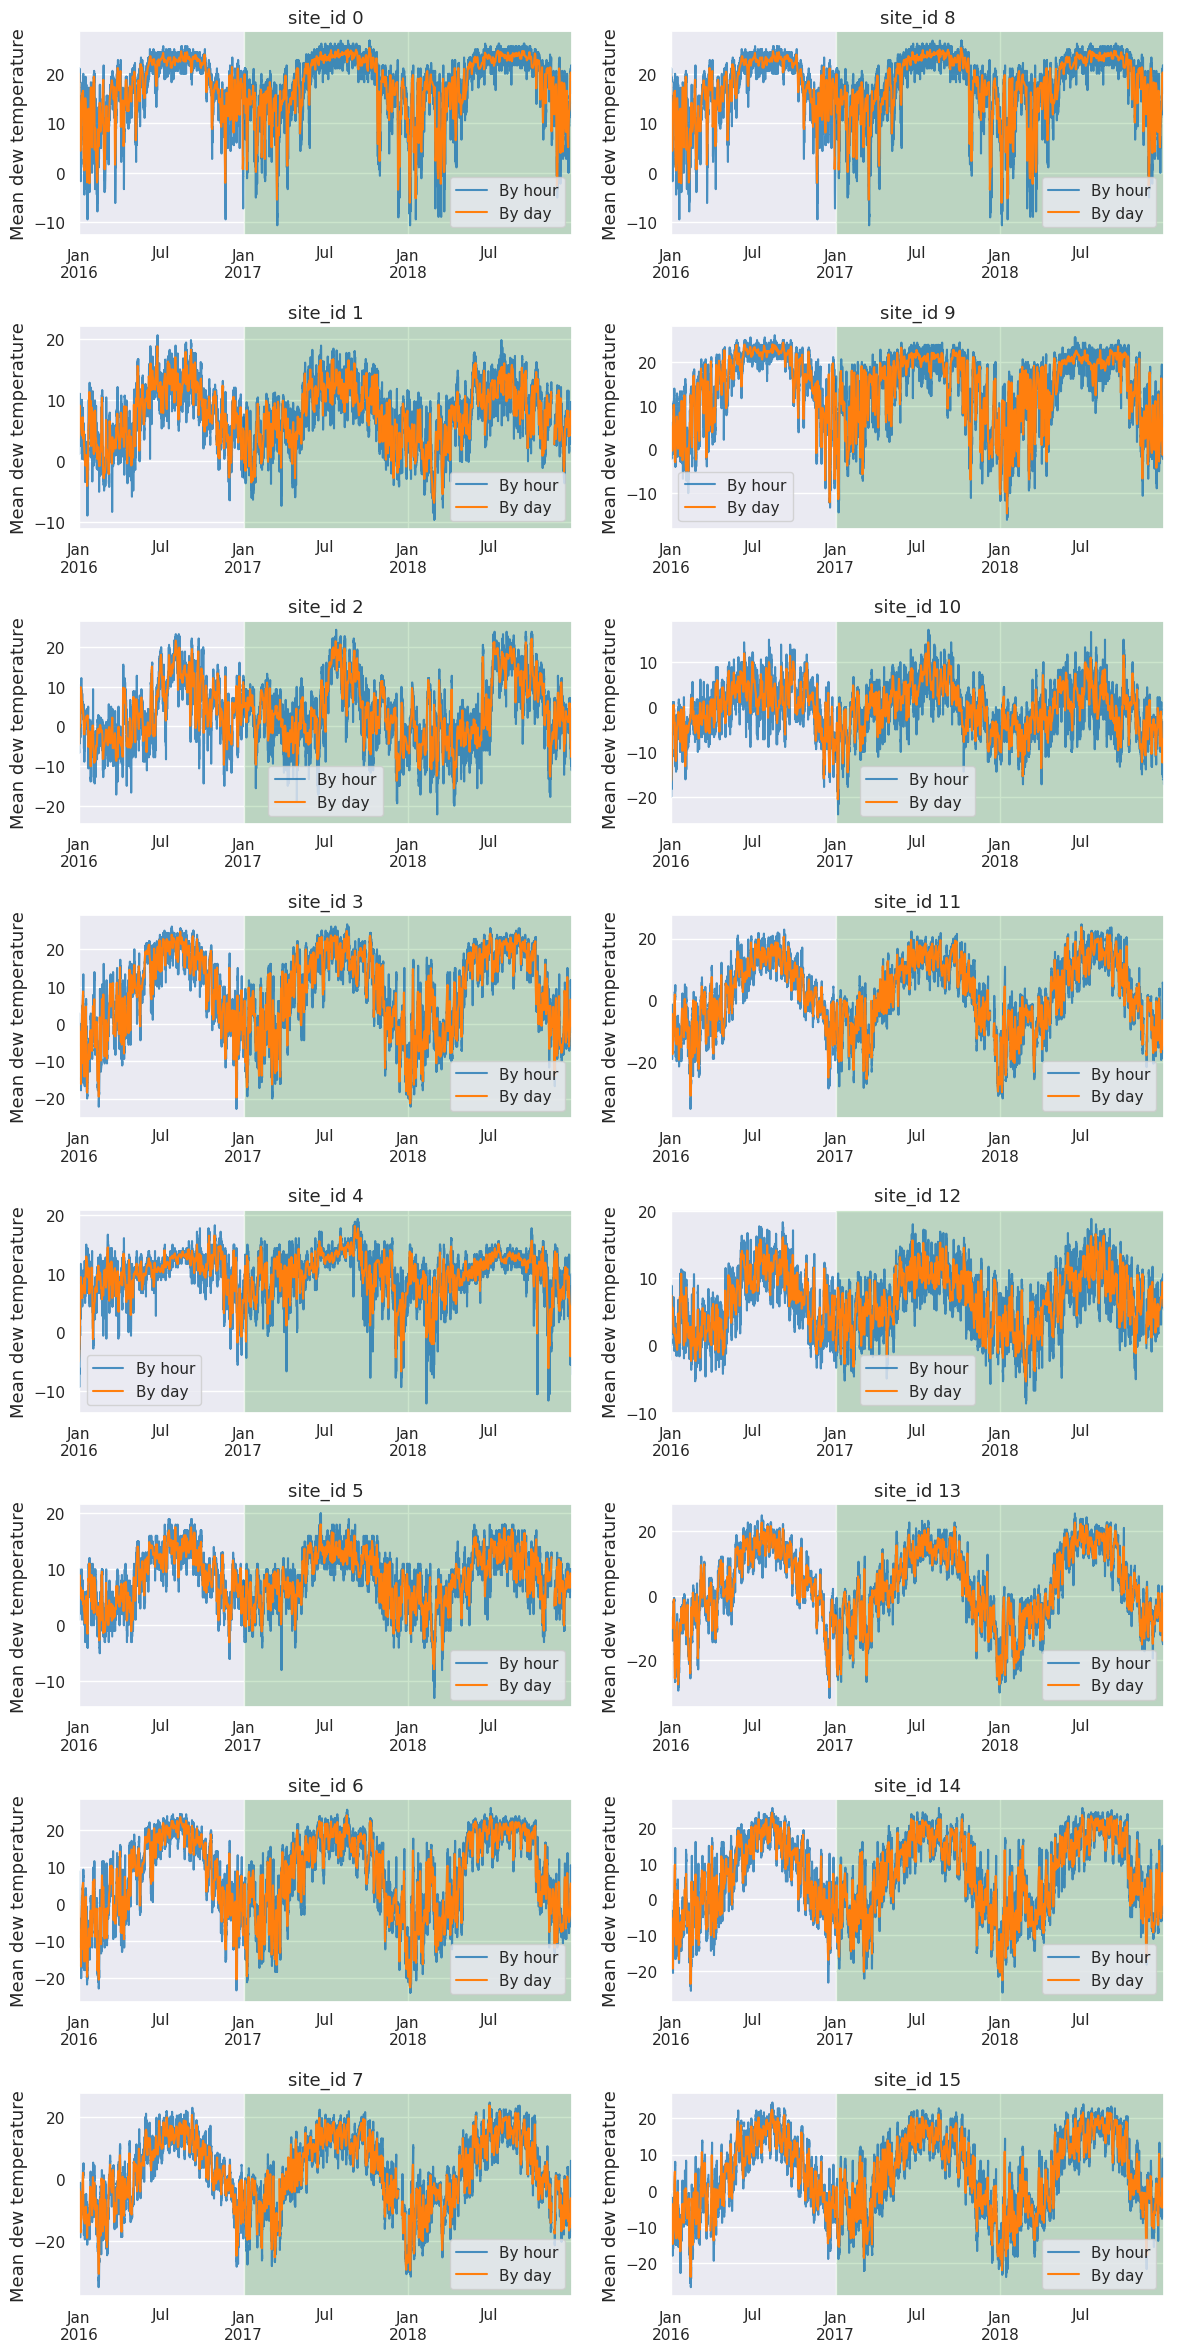

In [39]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

<a id="precip_depth_1_hr"></a>
# precip_depth_1_hr
precip_depth_1_hr - Millimeters

There are plenty of NaNs and you can see on the following plot that there is no information for Decemder 2016 - January 2017.

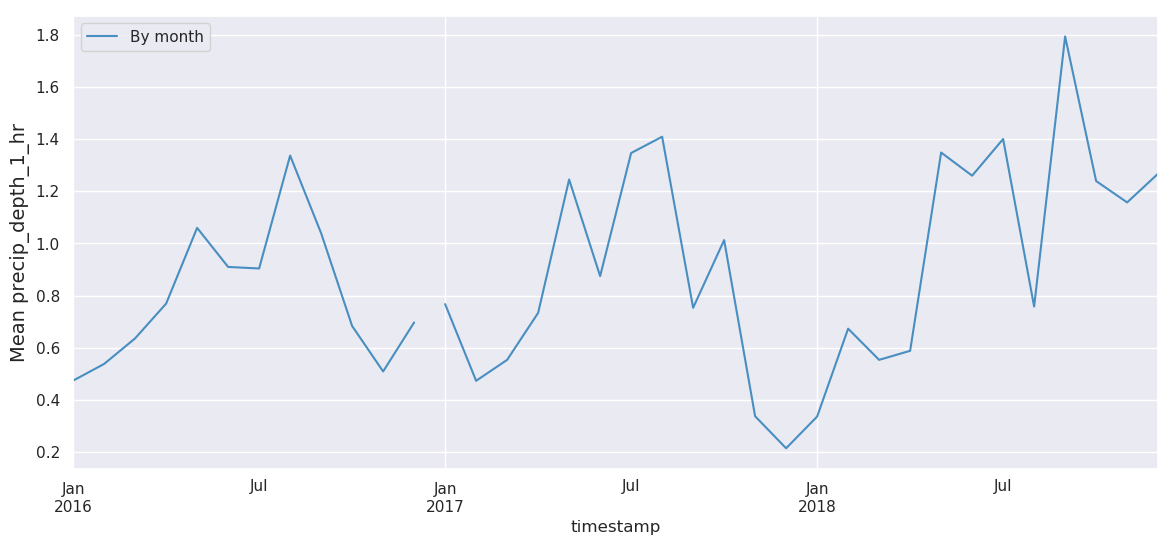

In [40]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, label='By month', color='tab:blue').set_ylabel('Mean precip_depth_1_hr', fontsize=14);
test[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
axes.legend();

<a id="sea_level_pressure"></a>

# sea_level_pressure

sea_level_pressure - Millibar/hectopascals

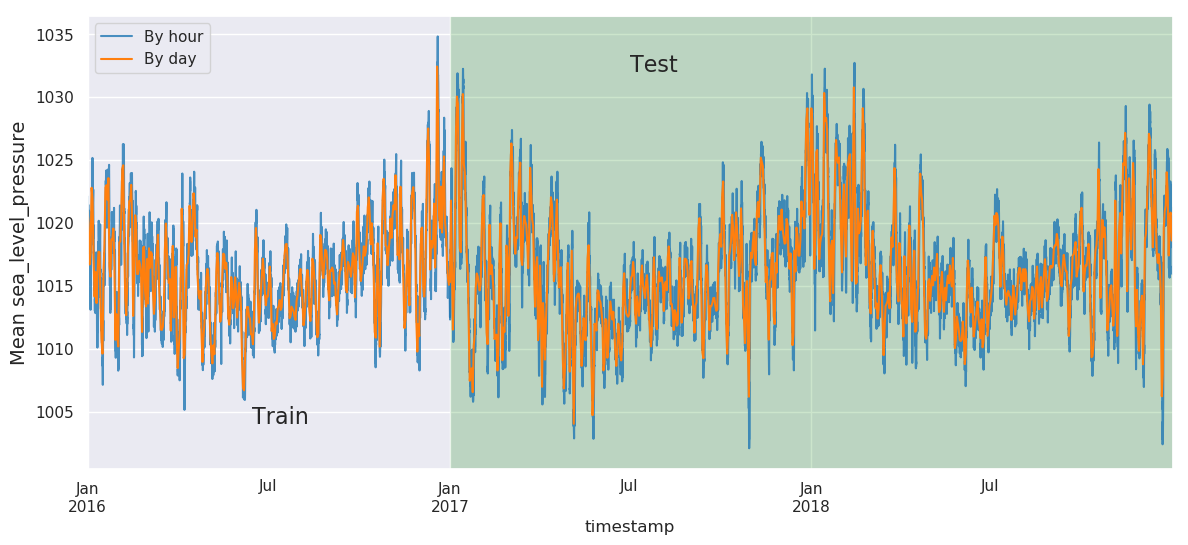

In [41]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=14);
test[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], 1004, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[21000000], 1032, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

And separate by site_id

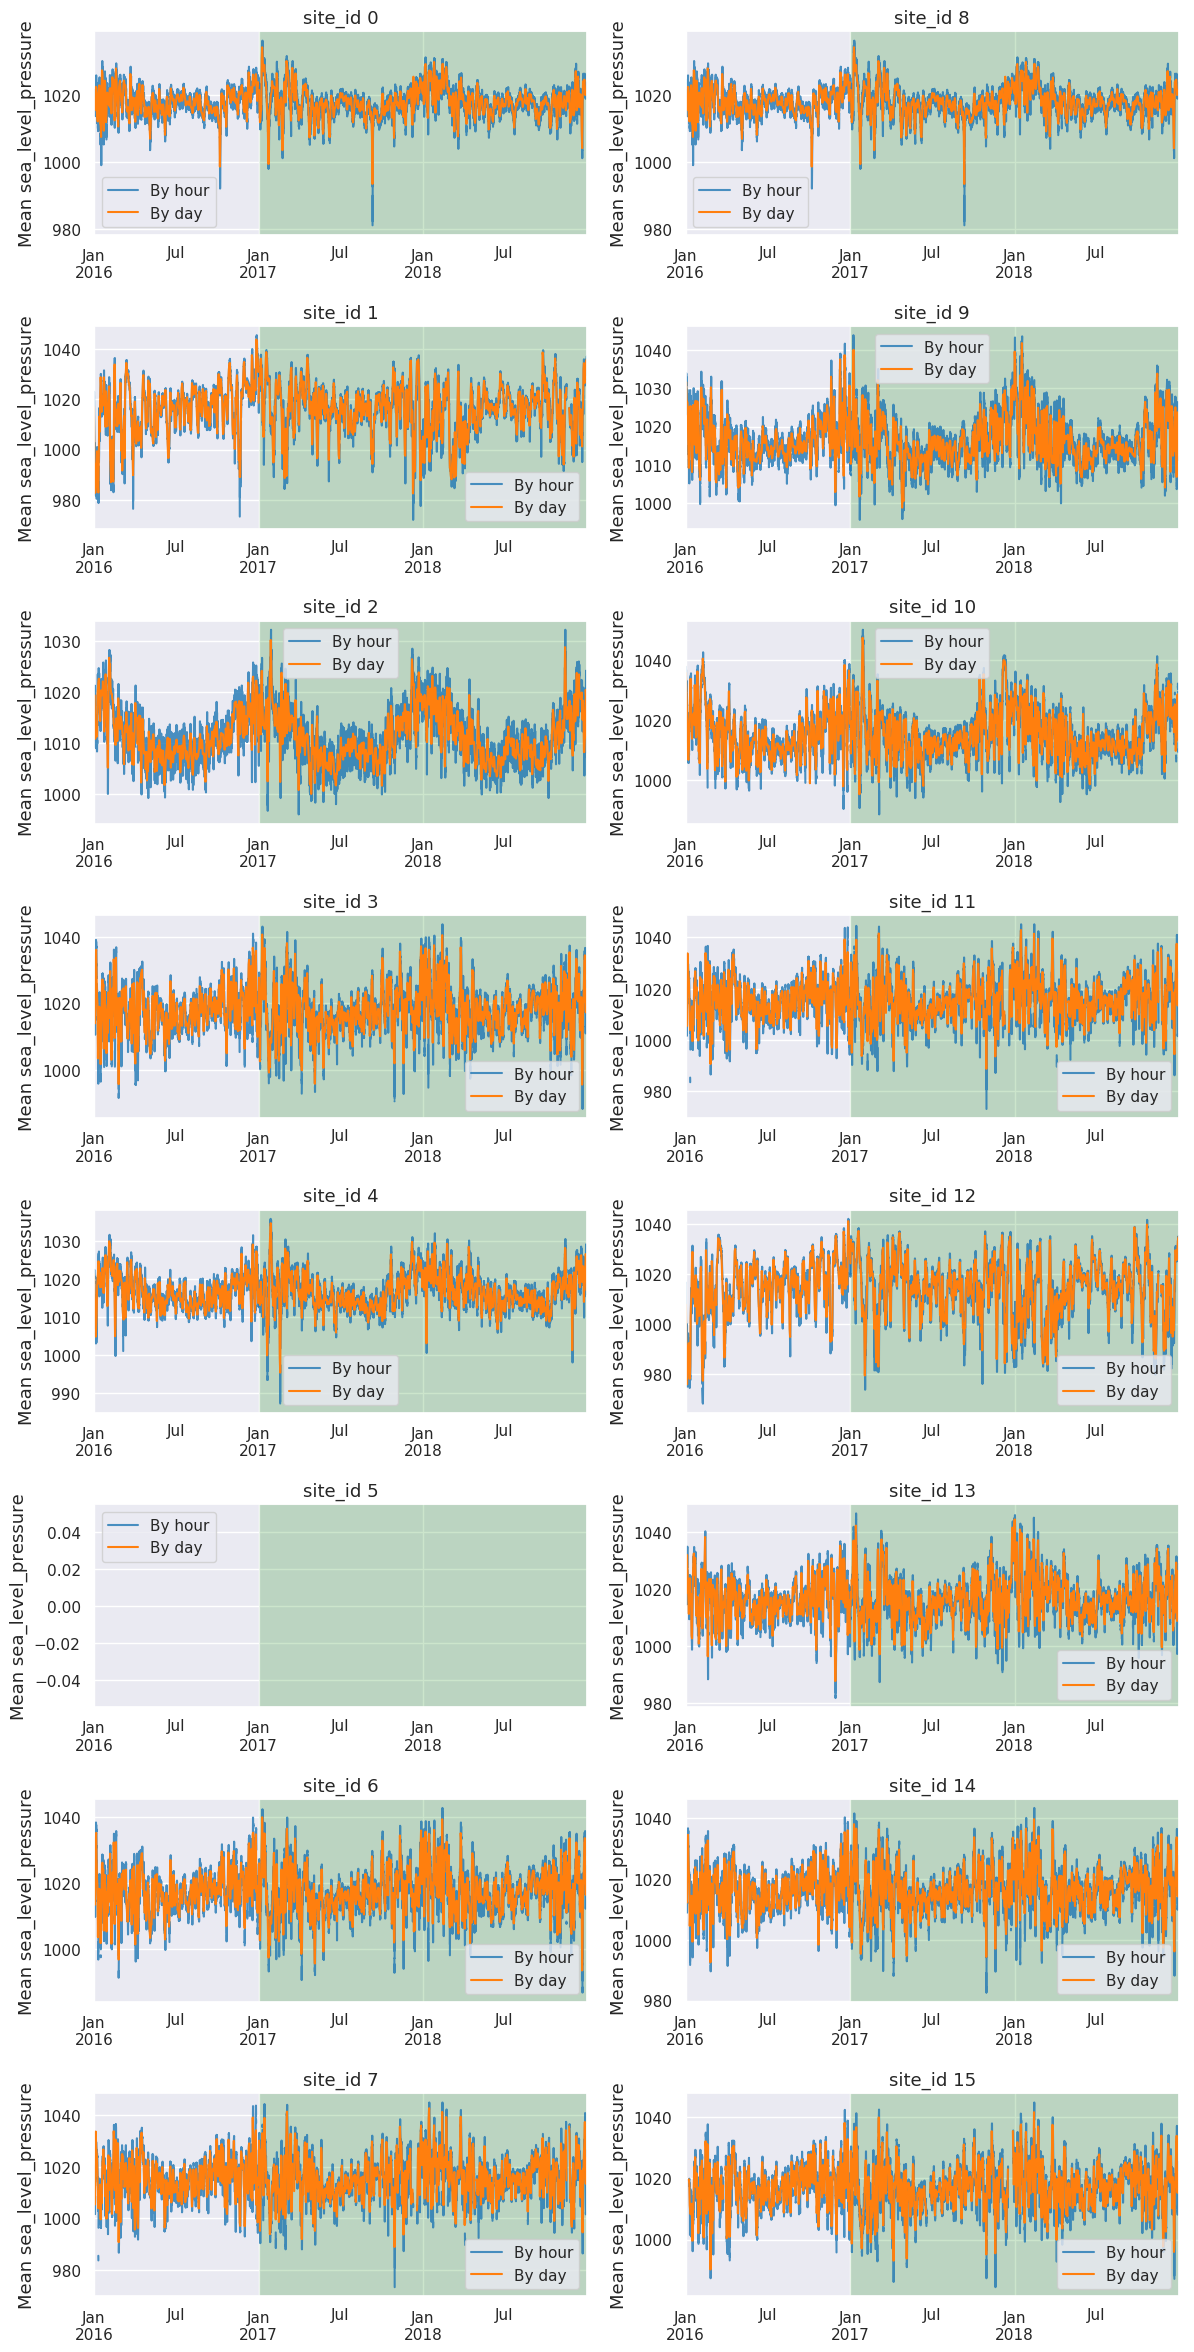

In [42]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

As we can see all values for site_id 5 are NaNs. Maybe there is no a pressure meter installed in that area?

In [43]:
train[train['site_id'] == 5]['sea_level_pressure'].value_counts(dropna=False)

NaN    781776
Name: sea_level_pressure, dtype: int64

<a id="wind_direction"></a>
# wind_direction & wind_speed

wind_direction - Compass direction (0-360)

wind_speed - Meters per second



Ok, plotting this is tricky, so I am going to do it using [this manual](https://gist.github.com/phobson/41b41bdd157a2bcf6e14)

First of all: direction of 0° and 360° is the same thing. But both are presented in the datasets.

In [44]:
print('Number of observations with 0 degree direction in TRAIN: {} ({:.2f}%)'.format(train[train['wind_direction'] == 0].shape[0], train[train['wind_direction'] == 0].shape[0] / len(train)))
print('Number of observations with 0 degree direction in TEST: {} ({:.2f}%)'.format(test[test['wind_direction'] == 0].shape[0], test[test['wind_direction'] == 0].shape[0] / len(test)))
print('Number of observations with 360 degree direction in TRAIN: {} ({:.2f}%)'.format(train[train['wind_direction'] == 360].shape[0], train[train['wind_direction'] == 360].shape[0] / len(train)))
print('Number of observations with 360 degree direction in TEST: {} ({:.2f}%)'.format(test[test['wind_direction'] == 360].shape[0], test[test['wind_direction'] == 360].shape[0] / len(test)))

Number of observations with 0 degree direction in TRAIN: 2373540 (0.12%)
Number of observations with 0 degree direction in TEST: 4796510 (0.12%)
Number of observations with 360 degree direction in TRAIN: 421533 (0.02%)
Number of observations with 360 degree direction in TEST: 813553 (0.02%)


Now lets see how many observations have calm conditions (wind speed is 0 meters per second)

In [45]:
print('Number of observations that have calm conditions in TRAIN: {} ({:.2f}%)'.format(train[train['wind_speed'] == 0].shape[0], train[train['wind_speed'] == 0].shape[0] / len(train)))
print('Number of observations that have calm conditions in TEST: {} ({:.2f}%)'.format(test[test['wind_speed'] == 0].shape[0], test[test['wind_speed'] == 0].shape[0] / len(test)))

Number of observations that have calm conditions in TRAIN: 2384761 (0.12%)
Number of observations that have calm conditions in TEST: 4822497 (0.12%)


In [46]:
def speed_labels(bins:list, units:str) -> list:   
    labels = list()
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return labels

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, np.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

In [47]:
calm_count = train[train['wind_speed'] == 0].shape[0]
total_count = len(train)
rose = (train.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)
directions = np.arange(0, 360, 15)

In [48]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig

This is a wind rose for TRAIN:

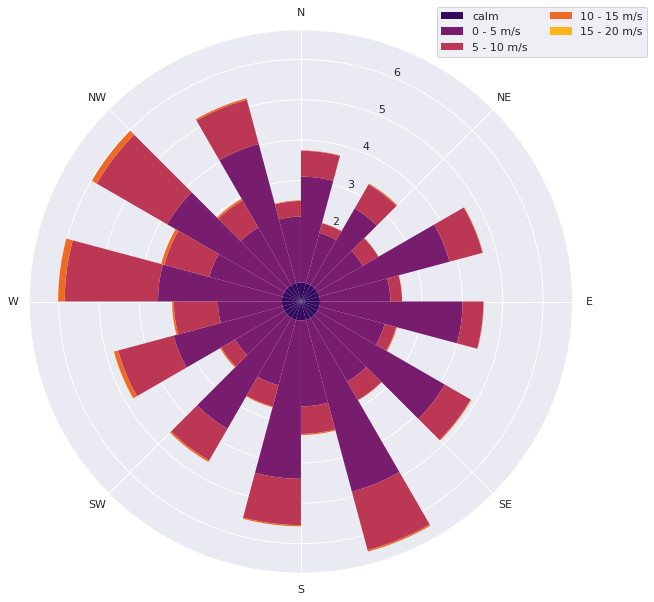

In [49]:
fig = wind_rose(rose, directions)

In [50]:
calm_count = test[test['wind_speed'] == 0].shape[0]
total_count = len(test)
rose = (test.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)

And wind rose for TEST

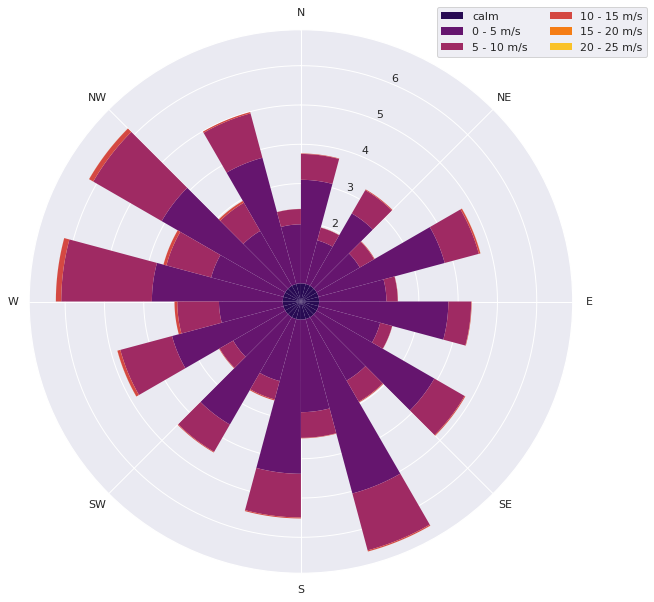

In [51]:
fig = wind_rose(rose, directions)

# Engineered features

Now lets add some new features and see if they might be usefull. First I am going to work with timeseries data.

<a id='Observation_hour'></a>
# Observation hour

An hour the meter reading was recorded.

In [52]:
train['hour'] = train['timestamp'].dt.hour
test['hour'] = test['timestamp'].dt.hour

One more evidence that train and test datasets are very well balanced. Number of observations per hour is almost the same.

Also we can see that energy consumption raises up during the day and lowers during the night hours.

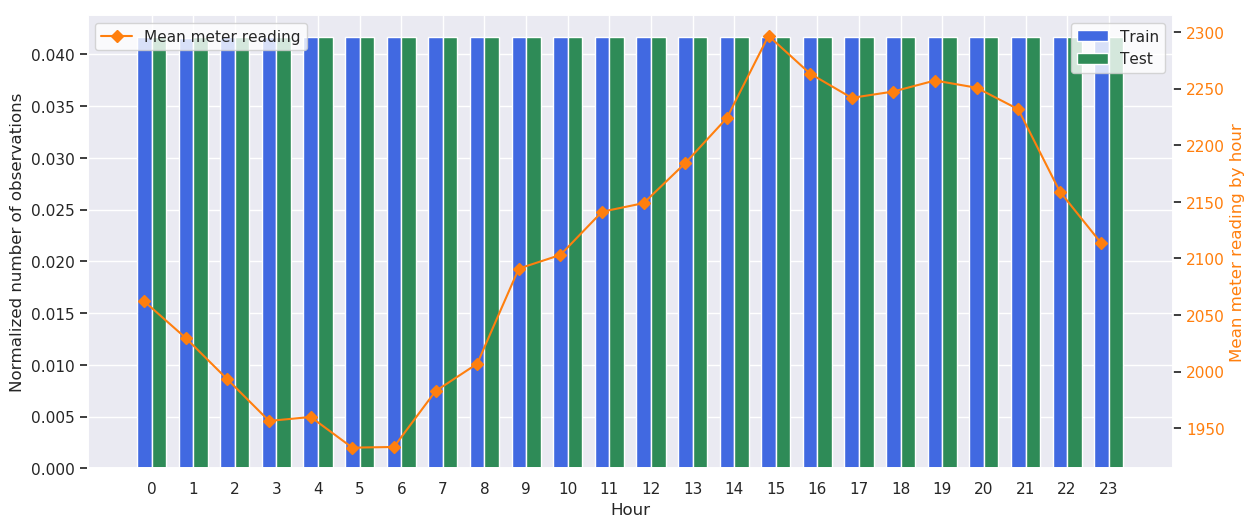

In [53]:
train_data = train['hour'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['hour'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['hour'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['hour', 'meter_reading']].groupby('hour')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

<a id='observ_day'></a>
# Observation day of month

A day of month the meter reading was recorded.

Number of observations for day 30 and 31 are lower than for other days, which makes sence - not every month have 30 or 31 days in it.

Also pay attention that number of observations for day 29 in training set is higher than in testing set. This is because training set contains observations of the year 2016, which was a leap year.

In [54]:
train['day'] = train['timestamp'].dt.day
test['day'] = test['timestamp'].dt.day

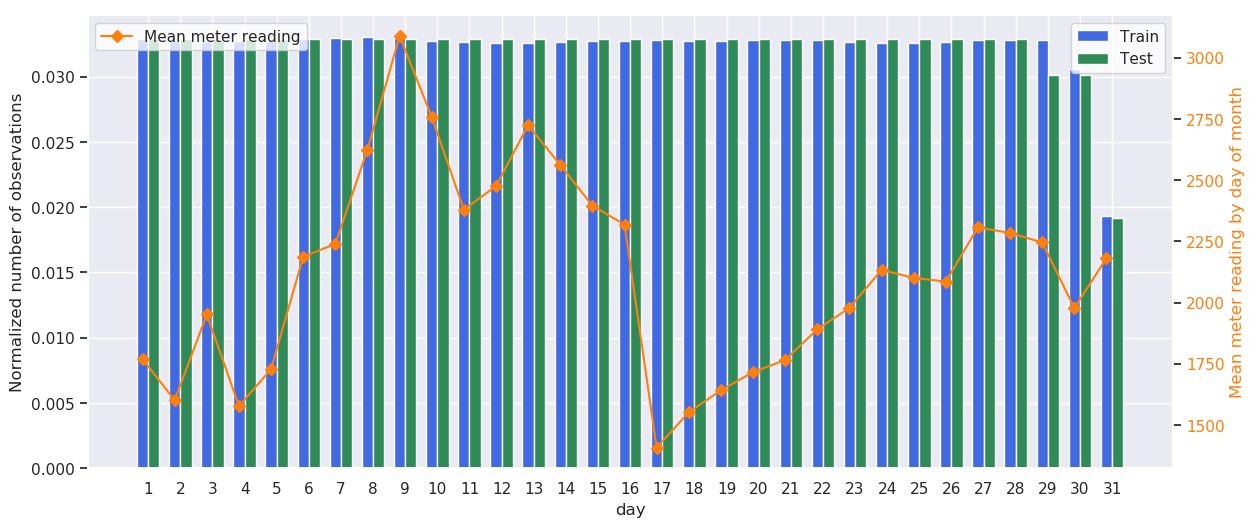

In [55]:
train_data = train['day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['day'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['day', 'meter_reading']].groupby('day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

<a id="observ_weekday"></a>
# Observation day of week

In [56]:
train['weekday'] = train['timestamp'].dt.weekday
test['weekday'] = test['timestamp'].dt.weekday

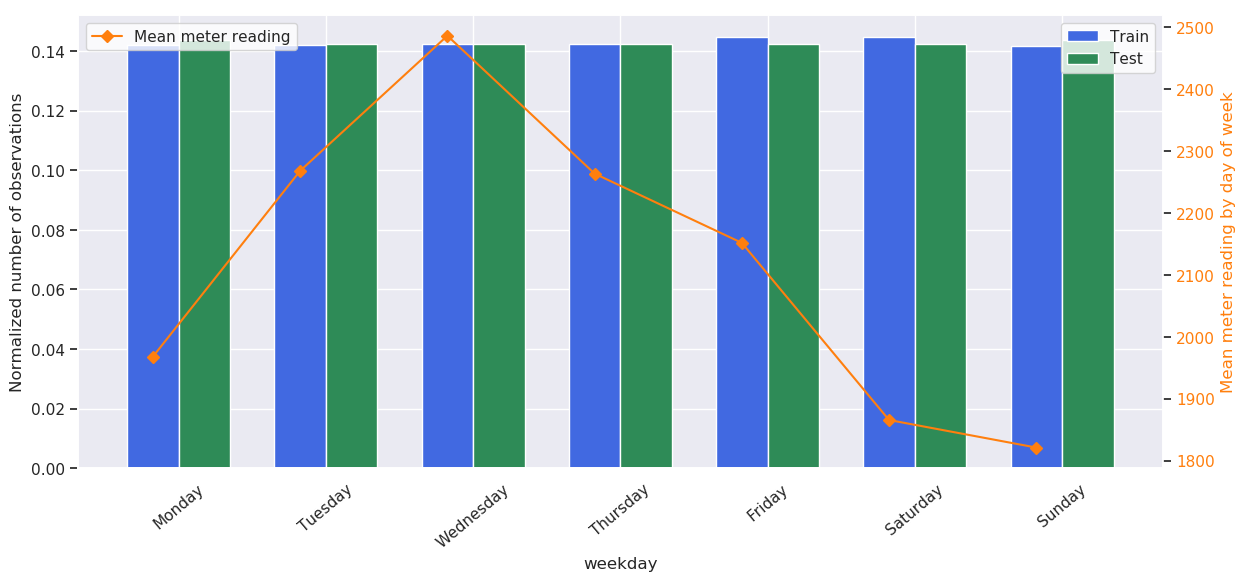

In [57]:
train_data = train['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['weekday', 'meter_reading']].groupby('weekday')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(train['weekday'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);